# End to End Process Mining Implementation: The Pythonic Way
## Library Imports

In [12]:
# import required libraries in PM4Py
import pm4py


from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization



# Other python libraries required for EDA
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math

## Reading the Event Data for EDA

In [13]:
# Reading the data to begin the analysis. Reading the event log in XES and then converting to dataframe

event_log_xes = pm4py.read_xes('BPI_Challenge_2012.xes')

event_log_df = pm4py.convert_to_dataframe(event_log_xes)


parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [14]:
# In this step I will first change the dutch activity names to english in a data frame and convert back the dataframe to xes format

event_log_df['concept:name'] = event_log_df['concept:name'].replace(['W_Completeren aanvraag','W_Nabellen offertes','W_Valideren aanvraag','W_Wijzigen contractgegevens','W_Afhandelen leads', 'W_Nabellen incomplete dossiers','W_Beoordelen fraude'],['W_Filling in information for the application','W_Calling after sent offers','W_Assessing the application','W_Change contract details','W_Fixing incoming lead','W_Calling to add missing information to the application','W_Assess fraud'])
event_log_df




org:resource lifecycle:transition  \
0               112             COMPLETE   
1               112             COMPLETE   
2               112             COMPLETE   
3               112             SCHEDULE   
4               NaN                START   
...             ...                  ...   
262195          112             COMPLETE   
262196          112             SCHEDULE   
262197        11169                START   
262198        11169             COMPLETE   
262199        11169             COMPLETE   

                                        concept:name  \
0                                        A_SUBMITTED   
1                                  A_PARTLYSUBMITTED   
2                                      A_PREACCEPTED   
3       W_Filling in information for the application   
4       W_Filling in information for the application   
...                                              ...   
262195                             A_PARTLYSUBMITTED   
262196                        W_Fixing incoming lead   
262197                        W_Fixing incoming lead   
262198                                    A_DECLINED   
262199                        W_Fixing incoming lead   

                          time:timestamp                     case:REG_DATE  \
0       2011-10-01 00:38:44.546000+02:00  2011-10-01 00:38:44.546000+02:00   
1       2011-10-01 00:38:44.880000+02:00  2011-10-01 00:38:44.546000+02:00   
2       2011-10-01 00:39:37.906000+02:00  2011-10-01 00:38:44.546000+02:00   
3       2011-10-01 00:39:38.875000+02:00  2011-10-01 00:38:44.546000+02:00   
4       2011-10-01 11:36:46.437000+02:00  2011-10-01 00:38:44.546000+02:00   
...                                  ...                               ...   
262195  2012-02-29 23:51:17.423000+01:00  2012-02-29 23:51:16.799000+01:00   
262196  2012-02-29 23:52:01.287000+01:00  2012-02-29 23:51:16.799000+01:00   
262197  2012-03-01 09:26:46.736000+01:00  2012-02-29 23:51:16.799000+01:00   
262198  2012-03-01 09:27:37.118000+01:00  2012-02-29 23:51:16.799000+01:00   
262199  2012-03-01 09:27:41.325000+01:00  2012-02-29 23:51:16.799000+01:00   

       case:concept:name case:AMOUNT_REQ  
0                 173688           20000  
1                 173688           20000  
2                 173688           20000  
3                 173688           20000  
4                 173688           20000  
...                  ...             ...  
262195            214376           15000  
262196            214376           15000  
262197            214376           15000  
262198            214376           15000  
262199            214376           15000  

[262200 rows x 7 columns]

In [15]:
# Converting the dataframe back to event log with the translated english acitivty names
event_log_xes = pm4py.convert_to_event_log(event_log_df)

## EDA techniques using PM4Py library

In [16]:
# Viewing the first trace in the event log
event_log_xes[0]
# len(event_log_xes[0])

{'attributes': {'REG_DATE': Timestamp('2011-10-01 00:38:44.546000+0200', tz='UTC+02:00'), 'concept:name': '173688', 'AMOUNT_REQ': '20000'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': Timestamp('2011-10-01 00:38:44.546000+0200', tz='UTC+02:00')}, '..', {'org:resource': '10629', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'W_Assessing the application', 'time:timestamp': Timestamp('2011-10-13 10:37:37.026000+0200', tz='UTC+02:00')}]}

In [17]:
# Viewing the first event in the first trace of the event log

event_log_xes[0][0]

{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': Timestamp('2011-10-01 00:38:44.546000+0200', tz='UTC+02:00')}

In [18]:
# Counting the number of events in the event log
len(event_log_xes)

13087

In [19]:
# Fetching the start ectivities
start_activities = pm4py.get_start_activities(event_log_xes)
start_activities

{'A_SUBMITTED': 13087}

In [20]:
# Fetching the end ectivities
end_activities = pm4py.get_end_activities(event_log_xes)
end_activities
# filter_activities = pm4py.filter_end_activities(event_log_xes, ['O_CANCELLED'])
# filter_activities

{'W_Assessing the application': 2747,
 'W_Change contract details': 4,
 'A_DECLINED': 3429,
 'W_Filling in information for the application': 1939,
 'A_CANCELLED': 655,
 'W_Calling to add missing information to the application': 452,
 'W_Fixing incoming lead': 2234,
 'W_Calling after sent offers': 1290,
 'W_Assess fraud': 57,
 'O_CANCELLED': 279,
 'A_REGISTERED': 1}

In [21]:
# Retrieving the number of activities in the event log

event_activities = pm4py.get_event_attribute_values(event_log_xes, 'concept:name')
event_activities

{'A_SUBMITTED': 13087,
 'A_PARTLYSUBMITTED': 13087,
 'A_PREACCEPTED': 7367,
 'W_Filling in information for the application': 54850,
 'A_ACCEPTED': 5113,
 'O_SELECTED': 7030,
 'A_FINALIZED': 5015,
 'O_CREATED': 7030,
 'O_SENT': 7030,
 'W_Calling after sent offers': 52016,
 'O_SENT_BACK': 3454,
 'W_Assessing the application': 20809,
 'A_REGISTERED': 2246,
 'A_APPROVED': 2246,
 'O_ACCEPTED': 2243,
 'A_ACTIVATED': 2246,
 'O_CANCELLED': 3655,
 'W_Change contract details': 12,
 'A_DECLINED': 7635,
 'A_CANCELLED': 2807,
 'W_Fixing incoming lead': 16566,
 'O_DECLINED': 802,
 'W_Calling to add missing information to the application': 25190,
 'W_Assess fraud': 664}

## EDA techniques using Pandas Library

In [22]:
# checking the dataframe
event_log_df.head(30)

org:resource lifecycle:transition  \
0           112             COMPLETE   
1           112             COMPLETE   
2           112             COMPLETE   
3           112             SCHEDULE   
4           NaN                START   
5         10862             COMPLETE   
6         10862             COMPLETE   
7         10862             COMPLETE   
8         10862             COMPLETE   
9         10862             COMPLETE   
10          NaN             SCHEDULE   
11          NaN             COMPLETE   
12          NaN                START   
13          NaN             COMPLETE   
14        10913                START   
15        10913             COMPLETE   
16        11049                START   
17        11049             COMPLETE   
18        11049             SCHEDULE   
19        11049             COMPLETE   
20        10629                START   
21        10629             COMPLETE   
22        10629             COMPLETE   
23        10629             COMPLETE   
24        10629             COMPLETE   
25        10629             COMPLETE   
26          112             COMPLETE   
27          112             COMPLETE   
28          112             COMPLETE   
29          112             SCHEDULE   

                                    concept:name  \
0                                    A_SUBMITTED   
1                              A_PARTLYSUBMITTED   
2                                  A_PREACCEPTED   
3   W_Filling in information for the application   
4   W_Filling in information for the application   
5                                     A_ACCEPTED   
6                                     O_SELECTED   
7                                    A_FINALIZED   
8                                      O_CREATED   
9                                         O_SENT   
10                   W_Calling after sent offers   
11  W_Filling in information for the application   
12                   W_Calling after sent offers   
13                   W_Calling after sent offers   
14                   W_Calling after sent offers   
15                   W_Calling after sent offers   
16                   W_Calling after sent offers   
17                                   O_SENT_BACK   
18                   W_Assessing the application   
19                   W_Calling after sent offers   
20                   W_Assessing the application   
21                                  A_REGISTERED   
22                                    A_APPROVED   
23                                    O_ACCEPTED   
24                                   A_ACTIVATED   
25                   W_Assessing the application   
26                                   A_SUBMITTED   
27                             A_PARTLYSUBMITTED   
28                                 A_PREACCEPTED   
29  W_Filling in information for the application   

                      time:timestamp                     case:REG_DATE  \
0   2011-10-01 00:38:44.546000+02:00  2011-10-01 00:38:44.546000+02:00   
1   2011-10-01 00:38:44.880000+02:00  2011-10-01 00:38:44.546000+02:00   
2   2011-10-01 00:39:37.906000+02:00  2011-10-01 00:38:44.546000+02:00   
3   2011-10-01 00:39:38.875000+02:00  2011-10-01 00:38:44.546000+02:00   
4   2011-10-01 11:36:46.437000+02:00  2011-10-01 00:38:44.546000+02:00   
5   2011-10-01 11:42:43.308000+02:00  2011-10-01 00:38:44.546000+02:00   
6   2011-10-01 11:45:09.243000+02:00  2011-10-01 00:38:44.546000+02:00   
7   2011-10-01 11:45:09.243000+02:00  2011-10-01 00:38:44.546000+02:00   
8   2011-10-01 11:45:11.197000+02:00  2011-10-01 00:38:44.546000+02:00   
9   2011-10-01 11:45:11.380000+02:00  2011-10-01 00:38:44.546000+02:00   
10  2011-10-01 11:45:11.554000+02:00  2011-10-01 00:38:44.546000+02:00   
11  2011-10-01 11:45:13.917000+02:00  2011-10-01 00:38:44.546000+02:00   
12  2011-10-01 12:15:41.290000+02:00  2011-10-01 00:38:44.546000+02:00   
13  2011-10-01 12:17:08.924000+02:00  2011-10-01 00:38:44.546000+02:00   
14  2011-10-08 16:26:57.720000+02:00  2

In [23]:
event_log_df.shape

(262200, 7)

In [24]:
#checking for any null value

event_log_df.isnull().sum()

org:resource            18010
lifecycle:transition        0
concept:name                0
time:timestamp              0
case:REG_DATE               0
case:concept:name           0
case:AMOUNT_REQ             0
dtype: int64

In [25]:
event_log_df.dtypes

org:resource            object
lifecycle:transition    object
concept:name            object
time:timestamp          object
case:REG_DATE           object
case:concept:name       object
case:AMOUNT_REQ         object
dtype: object

In [26]:
event_log_df.describe()

org:resource lifecycle:transition  \
count        244190               262200   
unique           68                    3   
top             112             COMPLETE   
freq          45687               164506   

                                        concept:name  \
count                                         262200   
unique                                            24   
top     W_Filling in information for the application   
freq                                           54850   

                          time:timestamp                     case:REG_DATE  \
count                             262200                            262200   
unique                            248189                             13087   
top     2011-11-16 12:54:02.245000+01:00  2011-11-15 13:42:45.592000+01:00   
freq                                   4                               175   

       case:concept:name case:AMOUNT_REQ  
count             262200          262200  
unique             13087             631  
top               185548            5000  
freq                 175           32988

In [27]:
# Fininding the list of events form the df

df_events = event_log_df['concept:name'].unique()
df_events

array(['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED',
       'W_Filling in information for the application', 'A_ACCEPTED',
       'O_SELECTED', 'A_FINALIZED', 'O_CREATED', 'O_SENT',
       'W_Calling after sent offers', 'O_SENT_BACK',
       'W_Assessing the application', 'A_REGISTERED', 'A_APPROVED',
       'O_ACCEPTED', 'A_ACTIVATED', 'O_CANCELLED',
       'W_Change contract details', 'A_DECLINED', 'A_CANCELLED',
       'W_Fixing incoming lead', 'O_DECLINED',
       'W_Calling to add missing information to the application',
       'W_Assess fraud'], dtype=object)

In [28]:
# Fetching the start activity using df

start_activities_df = pm4py.get_start_activities(event_log_df)
start_activities_df = pd.DataFrame.from_dict(start_activities_df,orient='index',columns=['Count'])
start_activities_df

Count
A_SUBMITTED  13087

In [29]:
# Fetching the end activity using df

end_activities_df = pm4py.get_end_activities(event_log_df)
end_activities_df = pd.DataFrame.from_dict(end_activities_df,orient='index',columns=['Count'])
end_activities_df

Count
A_DECLINED                                           3429
W_Assessing the application                          2747
W_Fixing incoming lead                               2234
W_Filling in information for the application         1939
W_Calling after sent offers                          1290
A_CANCELLED                                           655
W_Calling to add missing information to the app...    452
O_CANCELLED                                           279
W_Assess fraud                                         57
W_Change contract details                               4
A_REGISTERED                                            1

In [30]:
# Fetching the count of activities using df

activity_df = pm4py.get_event_attribute_values(event_log_df, 'concept:name')
activity_df

{'W_Filling in information for the application': 54850,
 'W_Calling after sent offers': 52016,
 'W_Calling to add missing information to the application': 25190,
 'W_Assessing the application': 20809,
 'W_Fixing incoming lead': 16566,
 'A_PARTLYSUBMITTED': 13087,
 'A_SUBMITTED': 13087,
 'A_DECLINED': 7635,
 'A_PREACCEPTED': 7367,
 'O_CREATED': 7030,
 'O_SENT': 7030,
 'O_SELECTED': 7030,
 'A_ACCEPTED': 5113,
 'A_FINALIZED': 5015,
 'O_CANCELLED': 3655,
 'O_SENT_BACK': 3454,
 'A_CANCELLED': 2807,
 'A_APPROVED': 2246,
 'A_ACTIVATED': 2246,
 'A_REGISTERED': 2246,
 'O_ACCEPTED': 2243,
 'O_DECLINED': 802,
 'W_Assess fraud': 664,
 'W_Change contract details': 12}

In [31]:
# splitting the df to application status only

application_status = ['A_ACCEPTED','A_ACTIVATED','A_APPROVED','A_CANCELLED','A_DECLINED','A_FINALIZED','A_PARTLYSUBMITTED','A_PREACCEPTED','A_REGISTERED','A_SUBMITTED']
offer_status = ['O_ACCEPTED' , 'O_CANCELLED', 'O_CREATED','O_DECLINED' , 'O_SELECTED', 'O_SENT', 'O_SENT_BACK']
workitem_status = ['W_Fixing incoming lead' , 'W_Assess fraud','W_Filling in information for the application','W_Calling to add missing information to the application','W_Calling after sent offers','W_Assessing the application','W_Change contract details']

app_status_df = event_log_df[event_log_df['concept:name'].isin(application_status)]
offer_status_df = event_log_df[event_log_df['concept:name'].isin(offer_status)]
workitem_staus_df = event_log_df[event_log_df['concept:name'].isin(workitem_status)]


In [32]:
app_status_df

org:resource lifecycle:transition       concept:name  \
0               112             COMPLETE        A_SUBMITTED   
1               112             COMPLETE  A_PARTLYSUBMITTED   
2               112             COMPLETE      A_PREACCEPTED   
5             10862             COMPLETE         A_ACCEPTED   
7             10862             COMPLETE        A_FINALIZED   
...             ...                  ...                ...   
262185        10933             COMPLETE         A_ACCEPTED   
262187        10933             COMPLETE        A_FINALIZED   
262194          112             COMPLETE        A_SUBMITTED   
262195          112             COMPLETE  A_PARTLYSUBMITTED   
262198        11169             COMPLETE         A_DECLINED   

                          time:timestamp                     case:REG_DATE  \
0       2011-10-01 00:38:44.546000+02:00  2011-10-01 00:38:44.546000+02:00   
1       2011-10-01 00:38:44.880000+02:00  2011-10-01 00:38:44.546000+02:00   
2       2011-10-01 00:39:37.906000+02:00  2011-10-01 00:38:44.546000+02:00   
5       2011-10-01 11:42:43.308000+02:00  2011-10-01 00:38:44.546000+02:00   
7       2011-10-01 11:45:09.243000+02:00  2011-10-01 00:38:44.546000+02:00   
...                                  ...                               ...   
262185  2012-03-01 20:17:22.457000+01:00  2012-02-29 23:43:09.766000+01:00   
262187  2012-03-01 20:22:38.593000+01:00  2012-02-29 23:43:09.766000+01:00   
262194  2012-02-29 23:51:16.799000+01:00  2012-02-29 23:51:16.799000+01:00   
262195  2012-02-29 23:51:17.423000+01:00  2012-02-29 23:51:16.799000+01:00   
262198  2012-03-01 09:27:37.118000+01:00  2012-02-29 23:51:16.799000+01:00   

       case:concept:name case:AMOUNT_REQ  
0                 173688           20000  
1                 173688           20000  
2                 173688           20000  
5                 173688           20000  
7                 173688           20000  
...                  ...             ...  
262185            214373            8500  
262187            214373            8500  
262194            214376           15000  
262195            214376           15000  
262198            214376           15000  

[60849 rows x 7 columns]

In [33]:
offer_status_df

org:resource lifecycle:transition concept:name  \
6             10862             COMPLETE   O_SELECTED   
8             10862             COMPLETE    O_CREATED   
9             10862             COMPLETE       O_SENT   
17            11049             COMPLETE  O_SENT_BACK   
23            10629             COMPLETE   O_ACCEPTED   
...             ...                  ...          ...   
262157        11003             COMPLETE       O_SENT   
262165        10789             COMPLETE  O_SENT_BACK   
262186        10933             COMPLETE   O_SELECTED   
262188        10933             COMPLETE    O_CREATED   
262189        10933             COMPLETE       O_SENT   

                          time:timestamp                     case:REG_DATE  \
6       2011-10-01 11:45:09.243000+02:00  2011-10-01 00:38:44.546000+02:00   
8       2011-10-01 11:45:11.197000+02:00  2011-10-01 00:38:44.546000+02:00   
9       2011-10-01 11:45:11.380000+02:00  2011-10-01 00:38:44.546000+02:00   
17      2011-10-10 11:33:03.668000+02:00  2011-10-01 00:38:44.546000+02:00   
23      2011-10-13 10:37:29.226000+02:00  2011-10-01 00:38:44.546000+02:00   
...                                  ...                               ...   
262157  2012-03-02 10:14:43.303000+01:00  2012-02-29 23:22:24.570000+01:00   
262165  2012-03-09 11:01:46.008000+01:00  2012-02-29 23:22:24.570000+01:00   
262186  2012-03-01 20:22:38.593000+01:00  2012-02-29 23:43:09.766000+01:00   
262188  2012-03-01 20:22:40.016000+01:00  2012-02-29 23:43:09.766000+01:00   
262189  2012-03-01 20:22:40.043000+01:00  2012-02-29 23:43:09.766000+01:00   

       case:concept:name case:AMOUNT_REQ  
6                 173688           20000  
8                 173688           20000  
9                 173688           20000  
17                173688           20000  
23                173688           20000  
...                  ...             ...  
262157            214364            5000  
262165            214364            5000  
262186            214373            8500  
262188            214373            8500  
262189            214373            8500  

[31244 rows x 7 columns]

In [34]:
workitem_staus_df

org:resource lifecycle:transition  \
3               112             SCHEDULE   
4               NaN                START   
10              NaN             SCHEDULE   
11              NaN             COMPLETE   
12              NaN                START   
...             ...                  ...   
262192        11119                START   
262193        11119             COMPLETE   
262196          112             SCHEDULE   
262197        11169                START   
262199        11169             COMPLETE   

                                        concept:name  \
3       W_Filling in information for the application   
4       W_Filling in information for the application   
10                       W_Calling after sent offers   
11      W_Filling in information for the application   
12                       W_Calling after sent offers   
...                                              ...   
262192                   W_Calling after sent offers   
262193                   W_Calling after sent offers   
262196                        W_Fixing incoming lead   
262197                        W_Fixing incoming lead   
262199                        W_Fixing incoming lead   

                          time:timestamp                     case:REG_DATE  \
3       2011-10-01 00:39:38.875000+02:00  2011-10-01 00:38:44.546000+02:00   
4       2011-10-01 11:36:46.437000+02:00  2011-10-01 00:38:44.546000+02:00   
10      2011-10-01 11:45:11.554000+02:00  2011-10-01 00:38:44.546000+02:00   
11      2011-10-01 11:45:13.917000+02:00  2011-10-01 00:38:44.546000+02:00   
12      2011-10-01 12:15:41.290000+02:00  2011-10-01 00:38:44.546000+02:00   
...                                  ...                               ...   
262192  2012-03-10 12:46:22.700000+01:00  2012-02-29 23:43:09.766000+01:00   
262193  2012-03-10 12:50:54.881000+01:00  2012-02-29 23:43:09.766000+01:00   
262196  2012-02-29 23:52:01.287000+01:00  2012-02-29 23:51:16.799000+01:00   
262197  2012-03-01 09:26:46.736000+01:00  2012-02-29 23:51:16.799000+01:00   
262199  2012-03-01 09:27:41.325000+01:00  2012-02-29 23:51:16.799000+01:00   

       case:concept:name case:AMOUNT_REQ  
3                 173688           20000  
4                 173688           20000  
10                173688           20000  
11                173688           20000  
12                173688           20000  
...                  ...             ...  
262192            214373            8500  
262193            214373            8500  
262196            214376           15000  
262197            214376           15000  
262199            214376           15000  

[170107 rows x 7 columns]

## Performing Process Variants Analysis in PM4Py
### Overall Process Variant Analysis of Loan Process

In [35]:
# Retrieving the number of variants in the event log

process_variants = pm4py.get_variants_as_tuples(event_log_xes)
process_variants
len(process_variants)

4366

In [109]:
total_variants_count = case_statistics.get_variant_statistics(event_log_xes)
total_variants_count

# Sorting top 5 process variants
total_variants_count = sorted(total_variants_count, key=lambda x:x['count'], reverse = True)
# total_variants_count (run this code to see all variants)
total_variants_count[0]
total_variants_count[1]
total_variants_count[2]
total_variants_count[3]
total_variants_count[4]
total_variants_count[5]

{'variant': ('A_SUBMITTED',
  'A_PARTLYSUBMITTED',
  'A_PREACCEPTED',
  'W_Filling in information for the application',
  'W_Filling in information for the application',
  'A_CANCELLED',
  'W_Filling in information for the application'),
 'count': 134}

In [37]:
k = 2
filtered_variant_log = pm4py.filter_variants_top_k(event_log_xes, k)
len(filtered_variant_log)
# filtered_variant_log

5301

In [38]:
# Putting the variants in a df

process_variants_df = pd.DataFrame.from_records(total_variants_count)
process_variants_df

variant  count
0          (A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED)   3429
1     (A_SUBMITTED, A_PARTLYSUBMITTED, W_Fixing inco...   1872
2     (A_SUBMITTED, A_PARTLYSUBMITTED, W_Fixing inco...    271
3     (A_SUBMITTED, A_PARTLYSUBMITTED, W_Fixing inco...    209
4     (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...    160
...                                                 ...    ...
4361  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...      1
4362  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...      1
4363  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...      1
4364  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...      1
4365  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...      1

[4366 rows x 2 columns]

In [39]:
process_variants_df.head(5)

variant  count
0       (A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED)   3429
1  (A_SUBMITTED, A_PARTLYSUBMITTED, W_Fixing inco...   1872
2  (A_SUBMITTED, A_PARTLYSUBMITTED, W_Fixing inco...    271
3  (A_SUBMITTED, A_PARTLYSUBMITTED, W_Fixing inco...    209
4  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...    160

### Analysing the process variants by Application Status

In [40]:
# Converting the df to event log

app_status_log = pm4py.convert_to_event_log(app_status_df)

In [41]:
process_variants_app = pm4py.get_variants_as_tuples(app_status_log)
process_variants_app
len(process_variants_app)

17

In [42]:
app_variants_count = case_statistics.get_variant_statistics(app_status_log)
app_variants_count

[{'variant': ('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED'),
  'count': 5719},
 {'variant': ('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'A_PREACCEPTED',
   'A_ACCEPTED',
   'A_FINALIZED',
   'A_CANCELLED'),
  'count': 1640},
 {'variant': ('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'A_PREACCEPTED',
   'A_CANCELLED'),
  'count': 1100},
 {'variant': ('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'A_PREACCEPTED',
   'A_DECLINED'),
  'count': 1085},
 {'variant': ('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'A_PREACCEPTED',
   'A_ACCEPTED',
   'A_FINALIZED',
   'A_DECLINED'),
  'count': 802},
 {'variant': ('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'A_PREACCEPTED',
   'A_ACCEPTED',
   'A_FINALIZED',
   'A_APPROVED',
   'A_REGISTERED',
   'A_ACTIVATED'),
  'count': 590},
 {'variant': ('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'A_PREACCEPTED',
   'A_ACCEPTED',
   'A_FINALIZED',
   'A_REGISTERED',
   'A_APPROVED',
   'A_ACTIVATED'),
  'count': 532},
 {'variant': ('A_SUBMITTED',
   'A_PARTLYSUBMITTED

In [43]:
app_variants_df = pd.DataFrame.from_records(app_variants_count)
app_variants_df.head(5) # top 5 variants

variant  count
0       (A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED)   5719
1  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...   1640
2  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...   1100
3  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...   1085
4  (A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...    802

### Analysing the process variants by Offer Status

In [44]:
# Converting the df to event log
offer_status_log = pm4py.convert_to_event_log(offer_status_df)

In [45]:
process_variants_offer = pm4py.get_variants_as_tuples(offer_status_log)
process_variants_offer
len(process_variants_offer)

168

In [46]:
offer_variants_count = case_statistics.get_variant_statistics(offer_status_log)
offer_variants_count

[{'variant': ('O_SELECTED',
   'O_CREATED',
   'O_SENT',
   'O_SENT_BACK',
   'O_ACCEPTED'),
  'count': 1537},
 {'variant': ('O_SELECTED', 'O_CREATED', 'O_SENT', 'O_CANCELLED'),
  'count': 1132},
 {'variant': ('O_SELECTED',
   'O_CREATED',
   'O_SENT',
   'O_SENT_BACK',
   'O_DECLINED'),
  'count': 574},
 {'variant': ('O_SELECTED',
   'O_CREATED',
   'O_SENT',
   'O_CANCELLED',
   'O_SELECTED',
   'O_CREATED',
   'O_SENT',
   'O_SENT_BACK',
   'O_ACCEPTED'),
  'count': 174},
 {'variant': ('O_SELECTED',
   'O_CREATED',
   'O_SENT',
   'O_CANCELLED',
   'O_SELECTED',
   'O_CREATED',
   'O_SENT',
   'O_CANCELLED'),
  'count': 157},
 {'variant': ('O_SELECTED', 'O_CREATED', 'O_SENT'), 'count': 151},
 {'variant': ('O_SELECTED',
   'O_CREATED',
   'O_SENT',
   'O_SELECTED',
   'O_CANCELLED',
   'O_CREATED',
   'O_SENT',
   'O_SENT_BACK',
   'O_ACCEPTED'),
  'count': 144},
 {'variant': ('O_SELECTED',
   'O_CREATED',
   'O_SENT',
   'O_SELECTED',
   'O_CANCELLED',
   'O_CREATED',
   'O_SENT',
 

In [47]:
offer_variants_df = pd.DataFrame.from_records(offer_variants_count)
offer_status_df.head(5) # top 5 variants

org:resource lifecycle:transition concept:name  \
6         10862             COMPLETE   O_SELECTED   
8         10862             COMPLETE    O_CREATED   
9         10862             COMPLETE       O_SENT   
17        11049             COMPLETE  O_SENT_BACK   
23        10629             COMPLETE   O_ACCEPTED   

                      time:timestamp                     case:REG_DATE  \
6   2011-10-01 11:45:09.243000+02:00  2011-10-01 00:38:44.546000+02:00   
8   2011-10-01 11:45:11.197000+02:00  2011-10-01 00:38:44.546000+02:00   
9   2011-10-01 11:45:11.380000+02:00  2011-10-01 00:38:44.546000+02:00   
17  2011-10-10 11:33:03.668000+02:00  2011-10-01 00:38:44.546000+02:00   
23  2011-10-13 10:37:29.226000+02:00  2011-10-01 00:38:44.546000+02:00   

   case:concept:name case:AMOUNT_REQ  
6             173688           20000  
8             173688           20000  
9             173688           20000  
17            173688           20000  
23            173688           20000

### Analysing the process variants by Workitem Status

In [48]:
# Converting the df to event log
workitem_status_log = pm4py.convert_to_event_log(workitem_staus_df)

In [49]:
process_variants_workitem = pm4py.get_variants_as_tuples(workitem_status_log)
process_variants_workitem
len(process_variants_workitem)

2643

In [50]:
workitem_variants_count = case_statistics.get_variant_statistics(workitem_status_log)
workitem_variants_count

[{'variant': ('W_Fixing incoming lead',
   'W_Fixing incoming lead',
   'W_Fixing incoming lead'),
  'count': 1872},
 {'variant': ('W_Filling in information for the application',
   'W_Filling in information for the application',
   'W_Filling in information for the application'),
  'count': 316},
 {'variant': ('W_Fixing incoming lead',
   'W_Fixing incoming lead',
   'W_Filling in information for the application',
   'W_Fixing incoming lead',
   'W_Filling in information for the application',
   'W_Filling in information for the application'),
  'count': 277},
 {'variant': ('W_Fixing incoming lead',
   'W_Fixing incoming lead',
   'W_Fixing incoming lead',
   'W_Fixing incoming lead',
   'W_Fixing incoming lead'),
  'count': 271},
 {'variant': ('W_Filling in information for the application',
   'W_Filling in information for the application',
   'W_Filling in information for the application',
   'W_Filling in information for the application',
   'W_Filling in information for the applic

In [51]:
workitem_variants_df = pd.DataFrame.from_records(workitem_variants_count)
workitem_variants_df.head(5) # top 5 variants

variant  count
0  (W_Fixing incoming lead, W_Fixing incoming lea...   1872
1  (W_Filling in information for the application,...    316
2  (W_Fixing incoming lead, W_Fixing incoming lea...    277
3  (W_Fixing incoming lead, W_Fixing incoming lea...    271
4  (W_Filling in information for the application,...    196

## Performing Process Discovery Techniques
### Discovery of Overall Loan Process- Alpha Miner

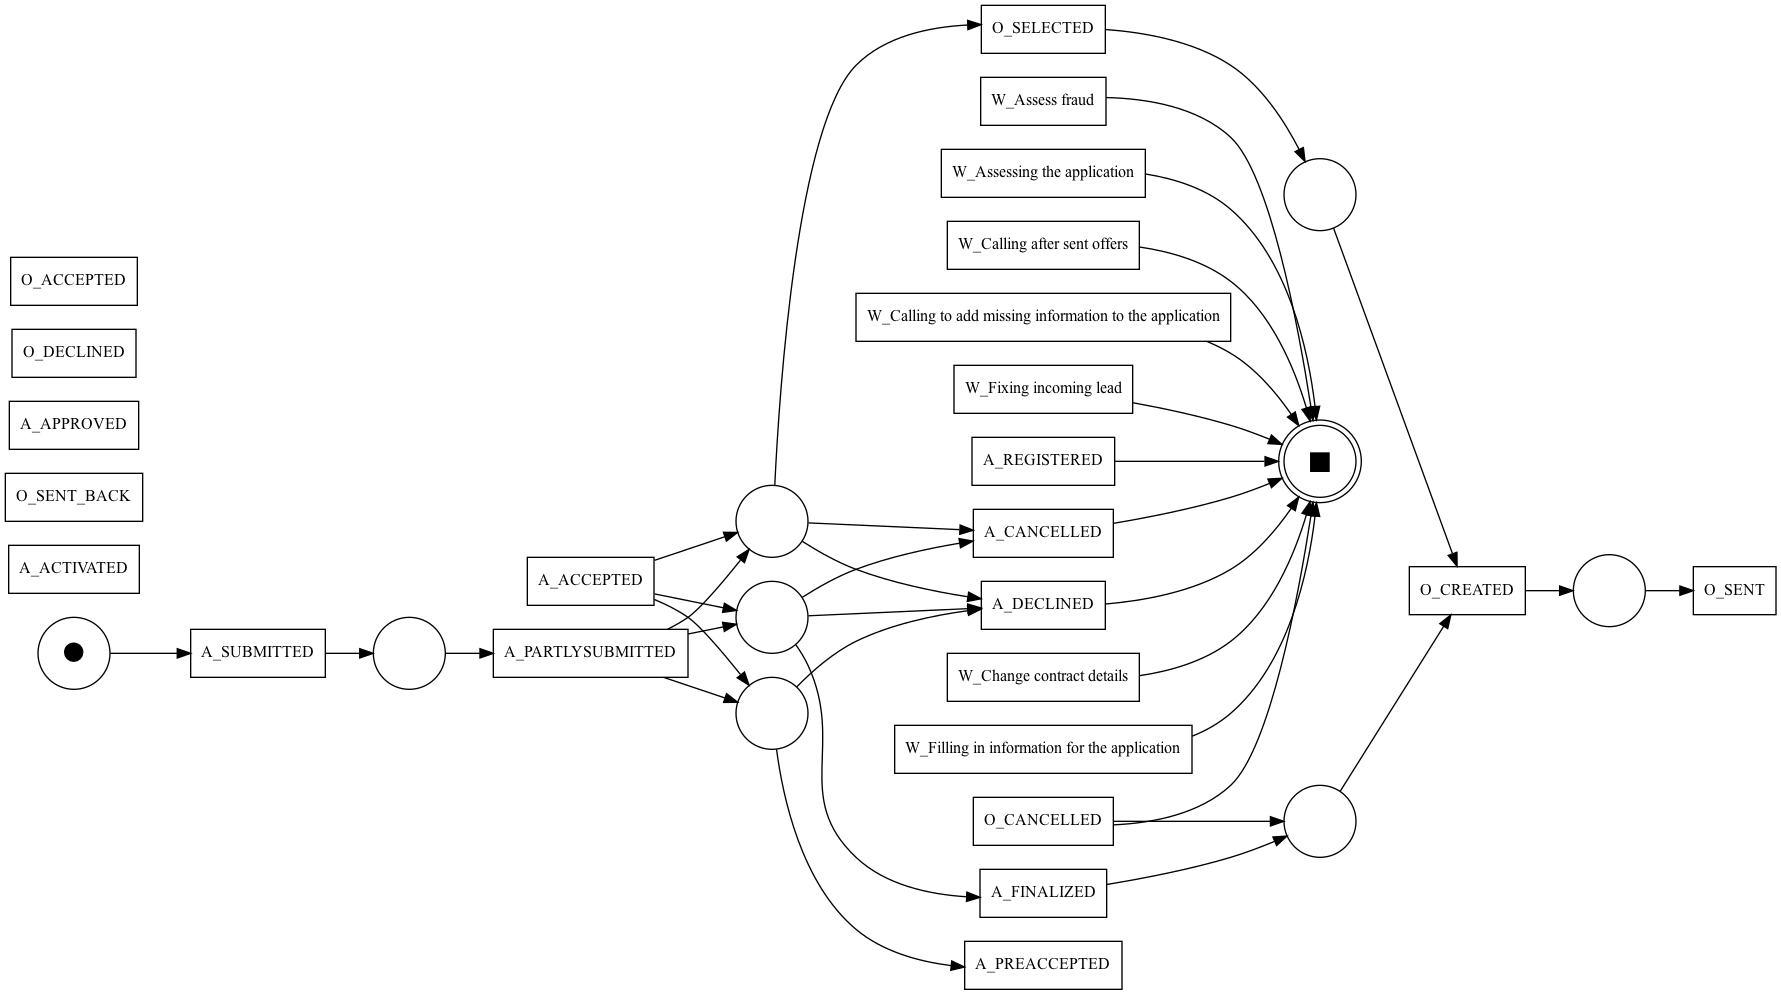

In [52]:
# Applying Alpha Miner Discovery Algorithm and visualising the process model

net, im, fm = alpha_miner.apply(event_log_xes)

gviz = pn_visualizer.apply(net, im, fm, log=event_log_xes)
pn_visualizer.view(gviz)

### Discovery of Overall Loan Process- Inductive Miner

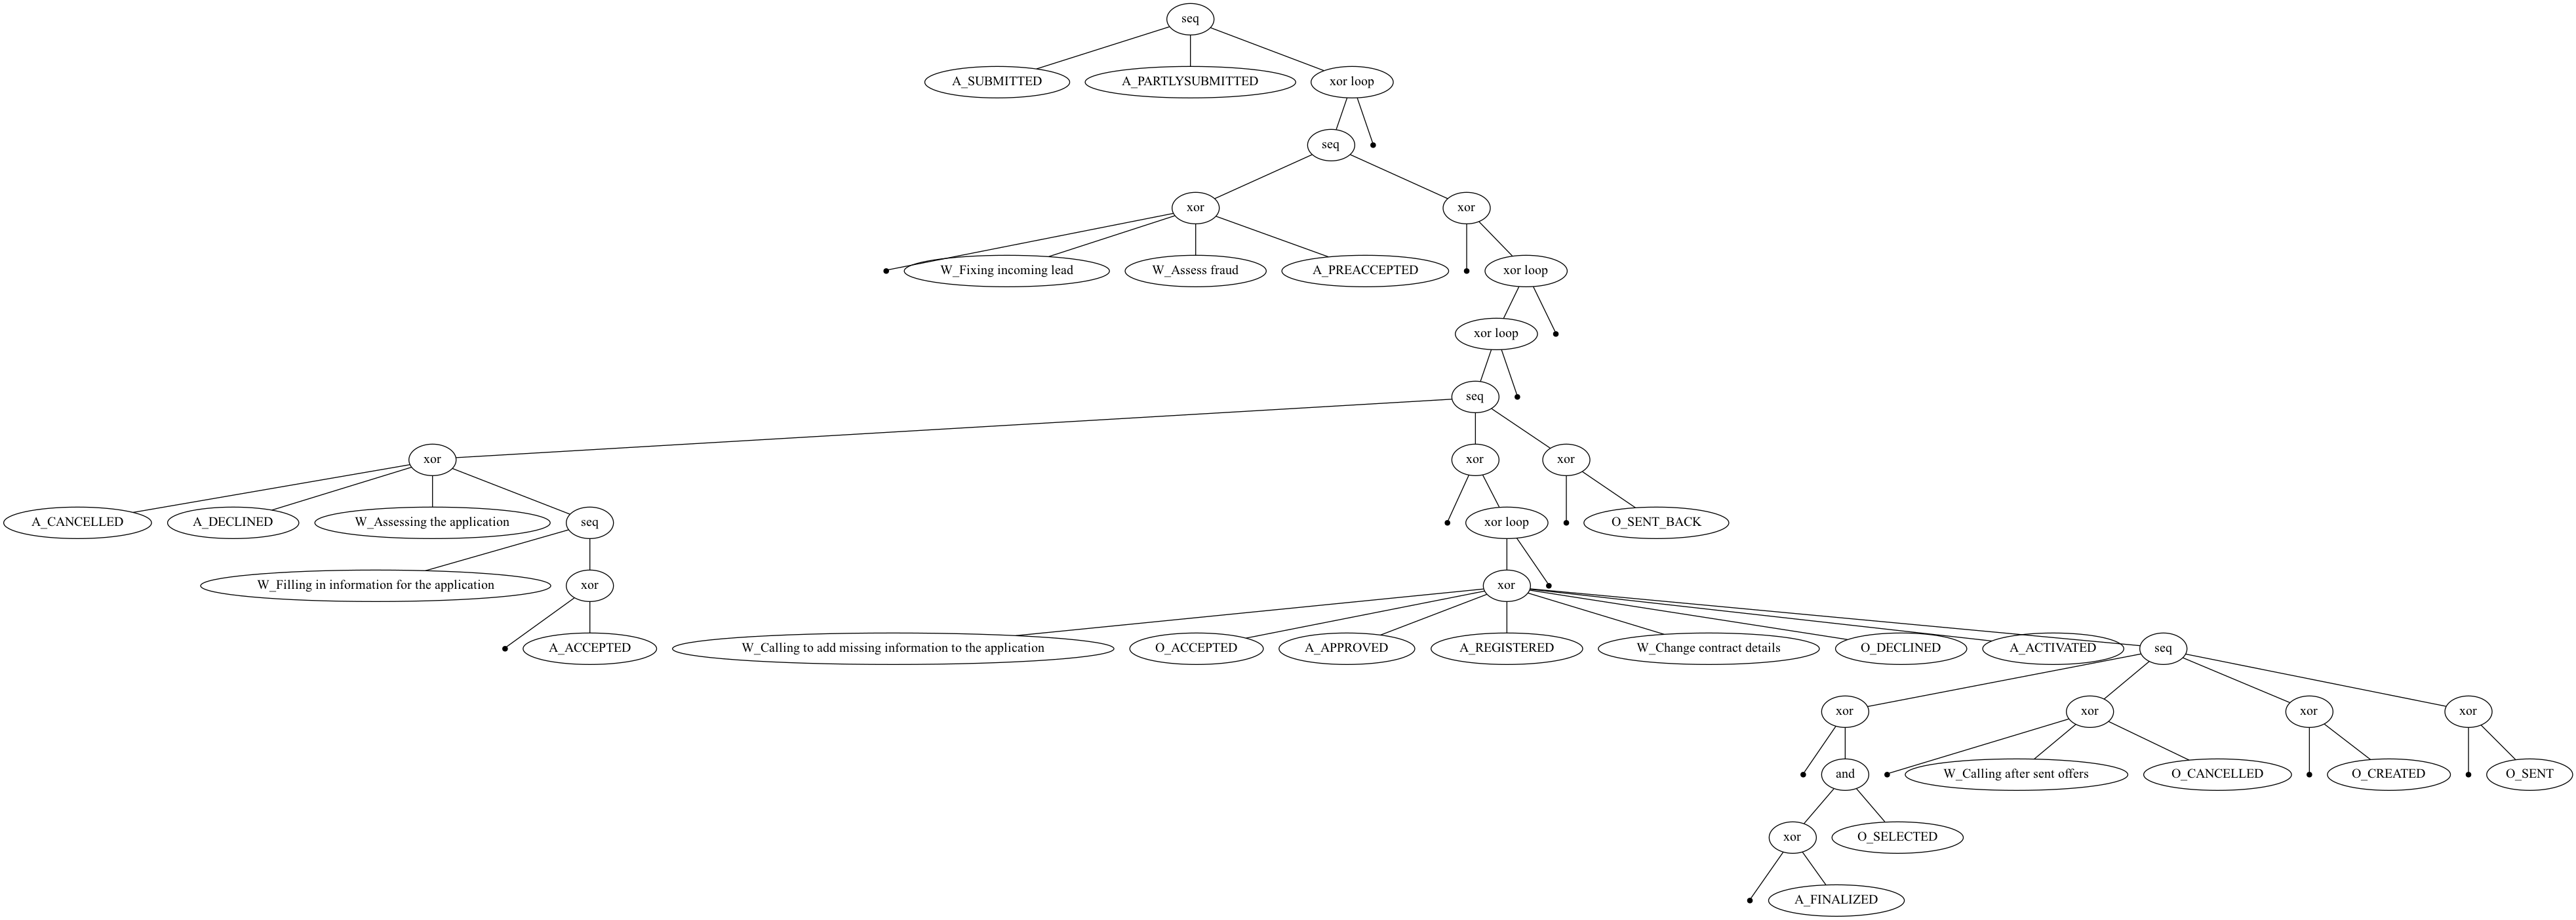

In [53]:
# Applying Inductive Miner Discovery Algorithm and visualising the process model using process tree

loan_process_tree = inductive_miner.apply_tree(event_log_xes)

gviz = pt_visualizer.apply(loan_process_tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)

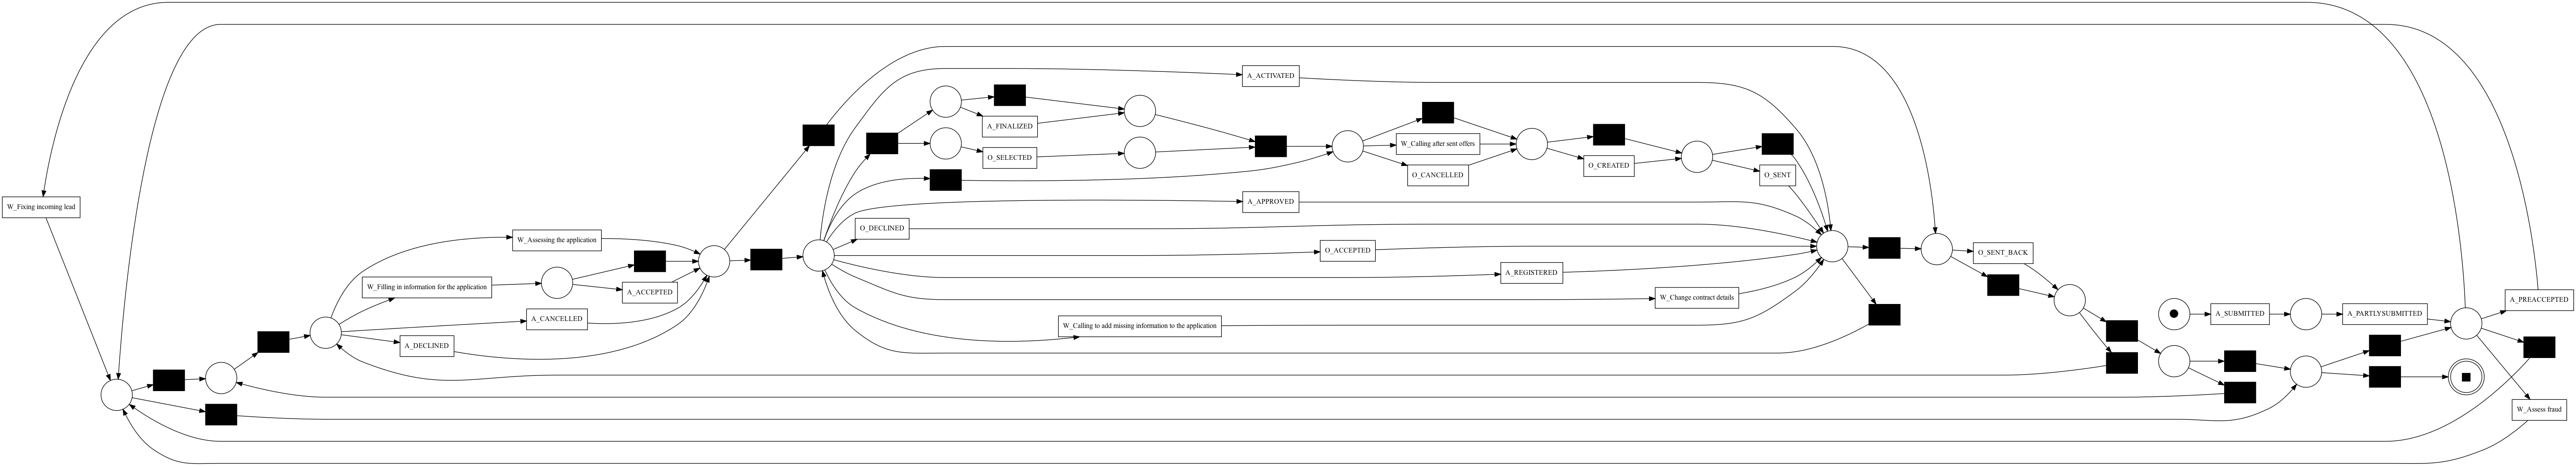

In [54]:
# Converting the Process Tree to Petri-net

net1, im1, fm1 = pt_converter.apply(loan_process_tree)
gviz = pn_visualizer.apply(net1, im1, fm1,
                           log=event_log_xes,parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pn_visualizer.view(gviz)

### Discovery of Overall Loan Process- Direct Flow Graphs (DFG) Miner


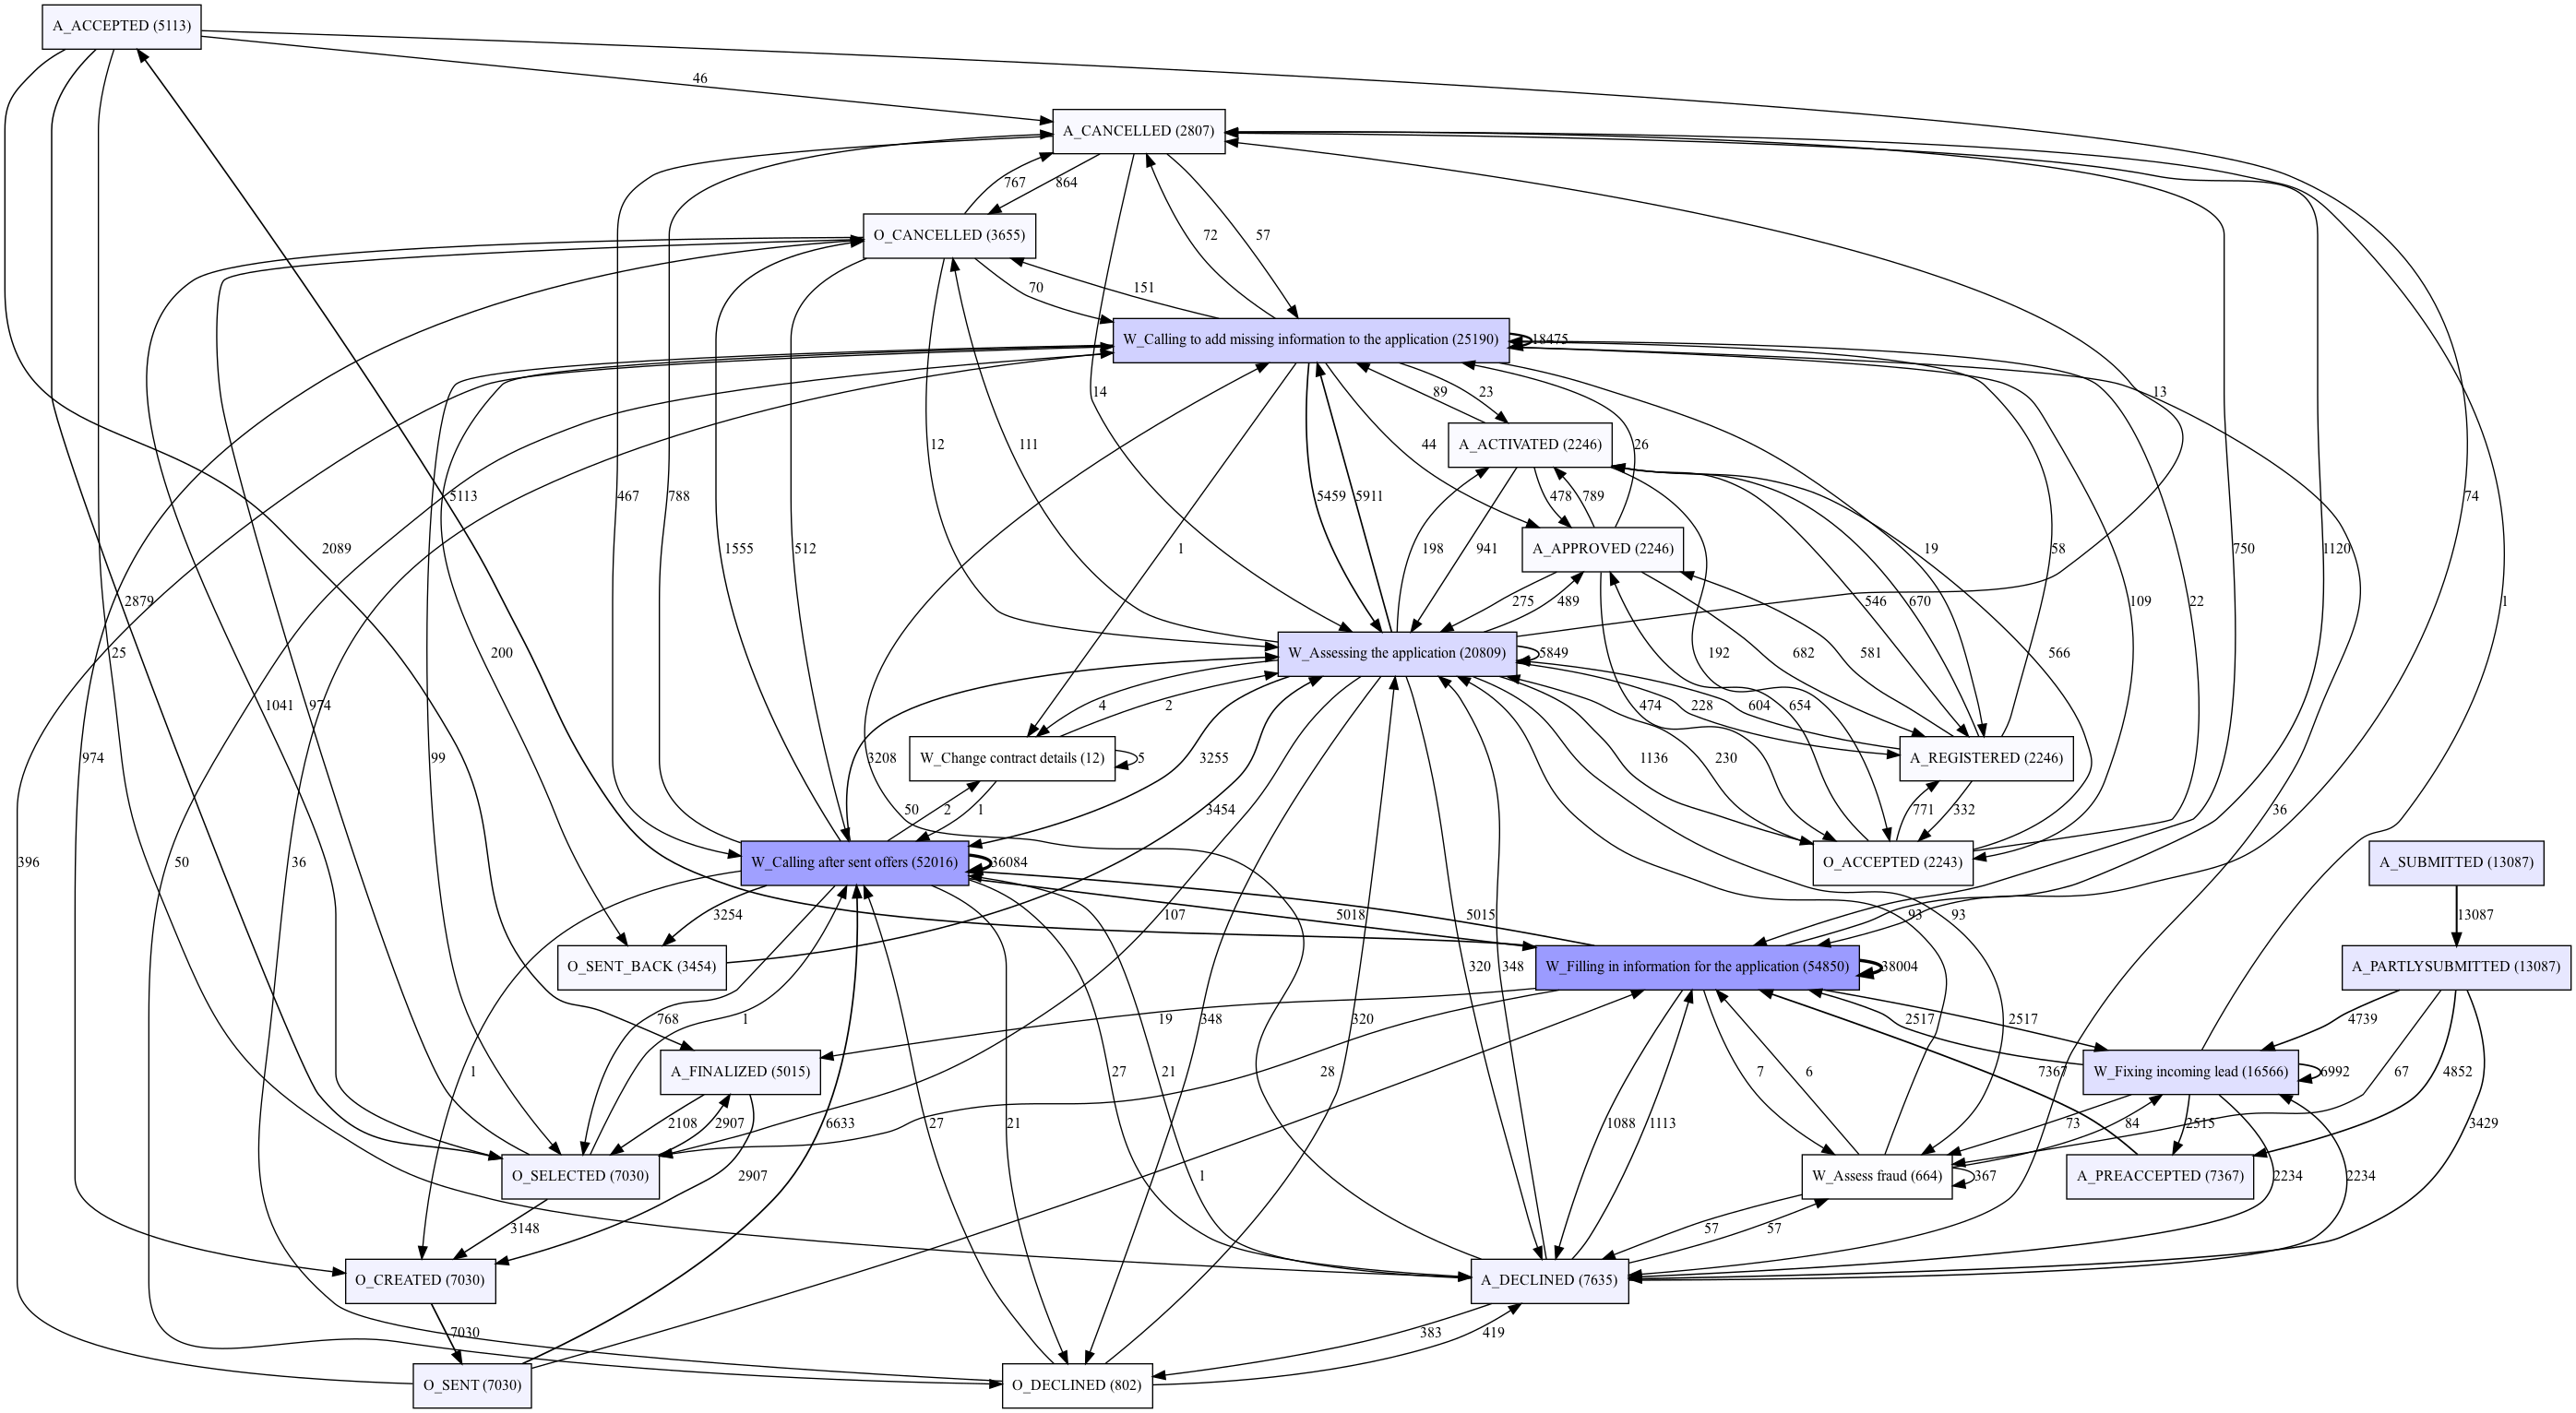

In [55]:
loan_process_dfg = dfg_discovery.apply(event_log_xes)

gviz = dfg_visualization.apply(loan_process_dfg, log=event_log_xes, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

### Discovery of Overall Loan Process- Heuristic Miner


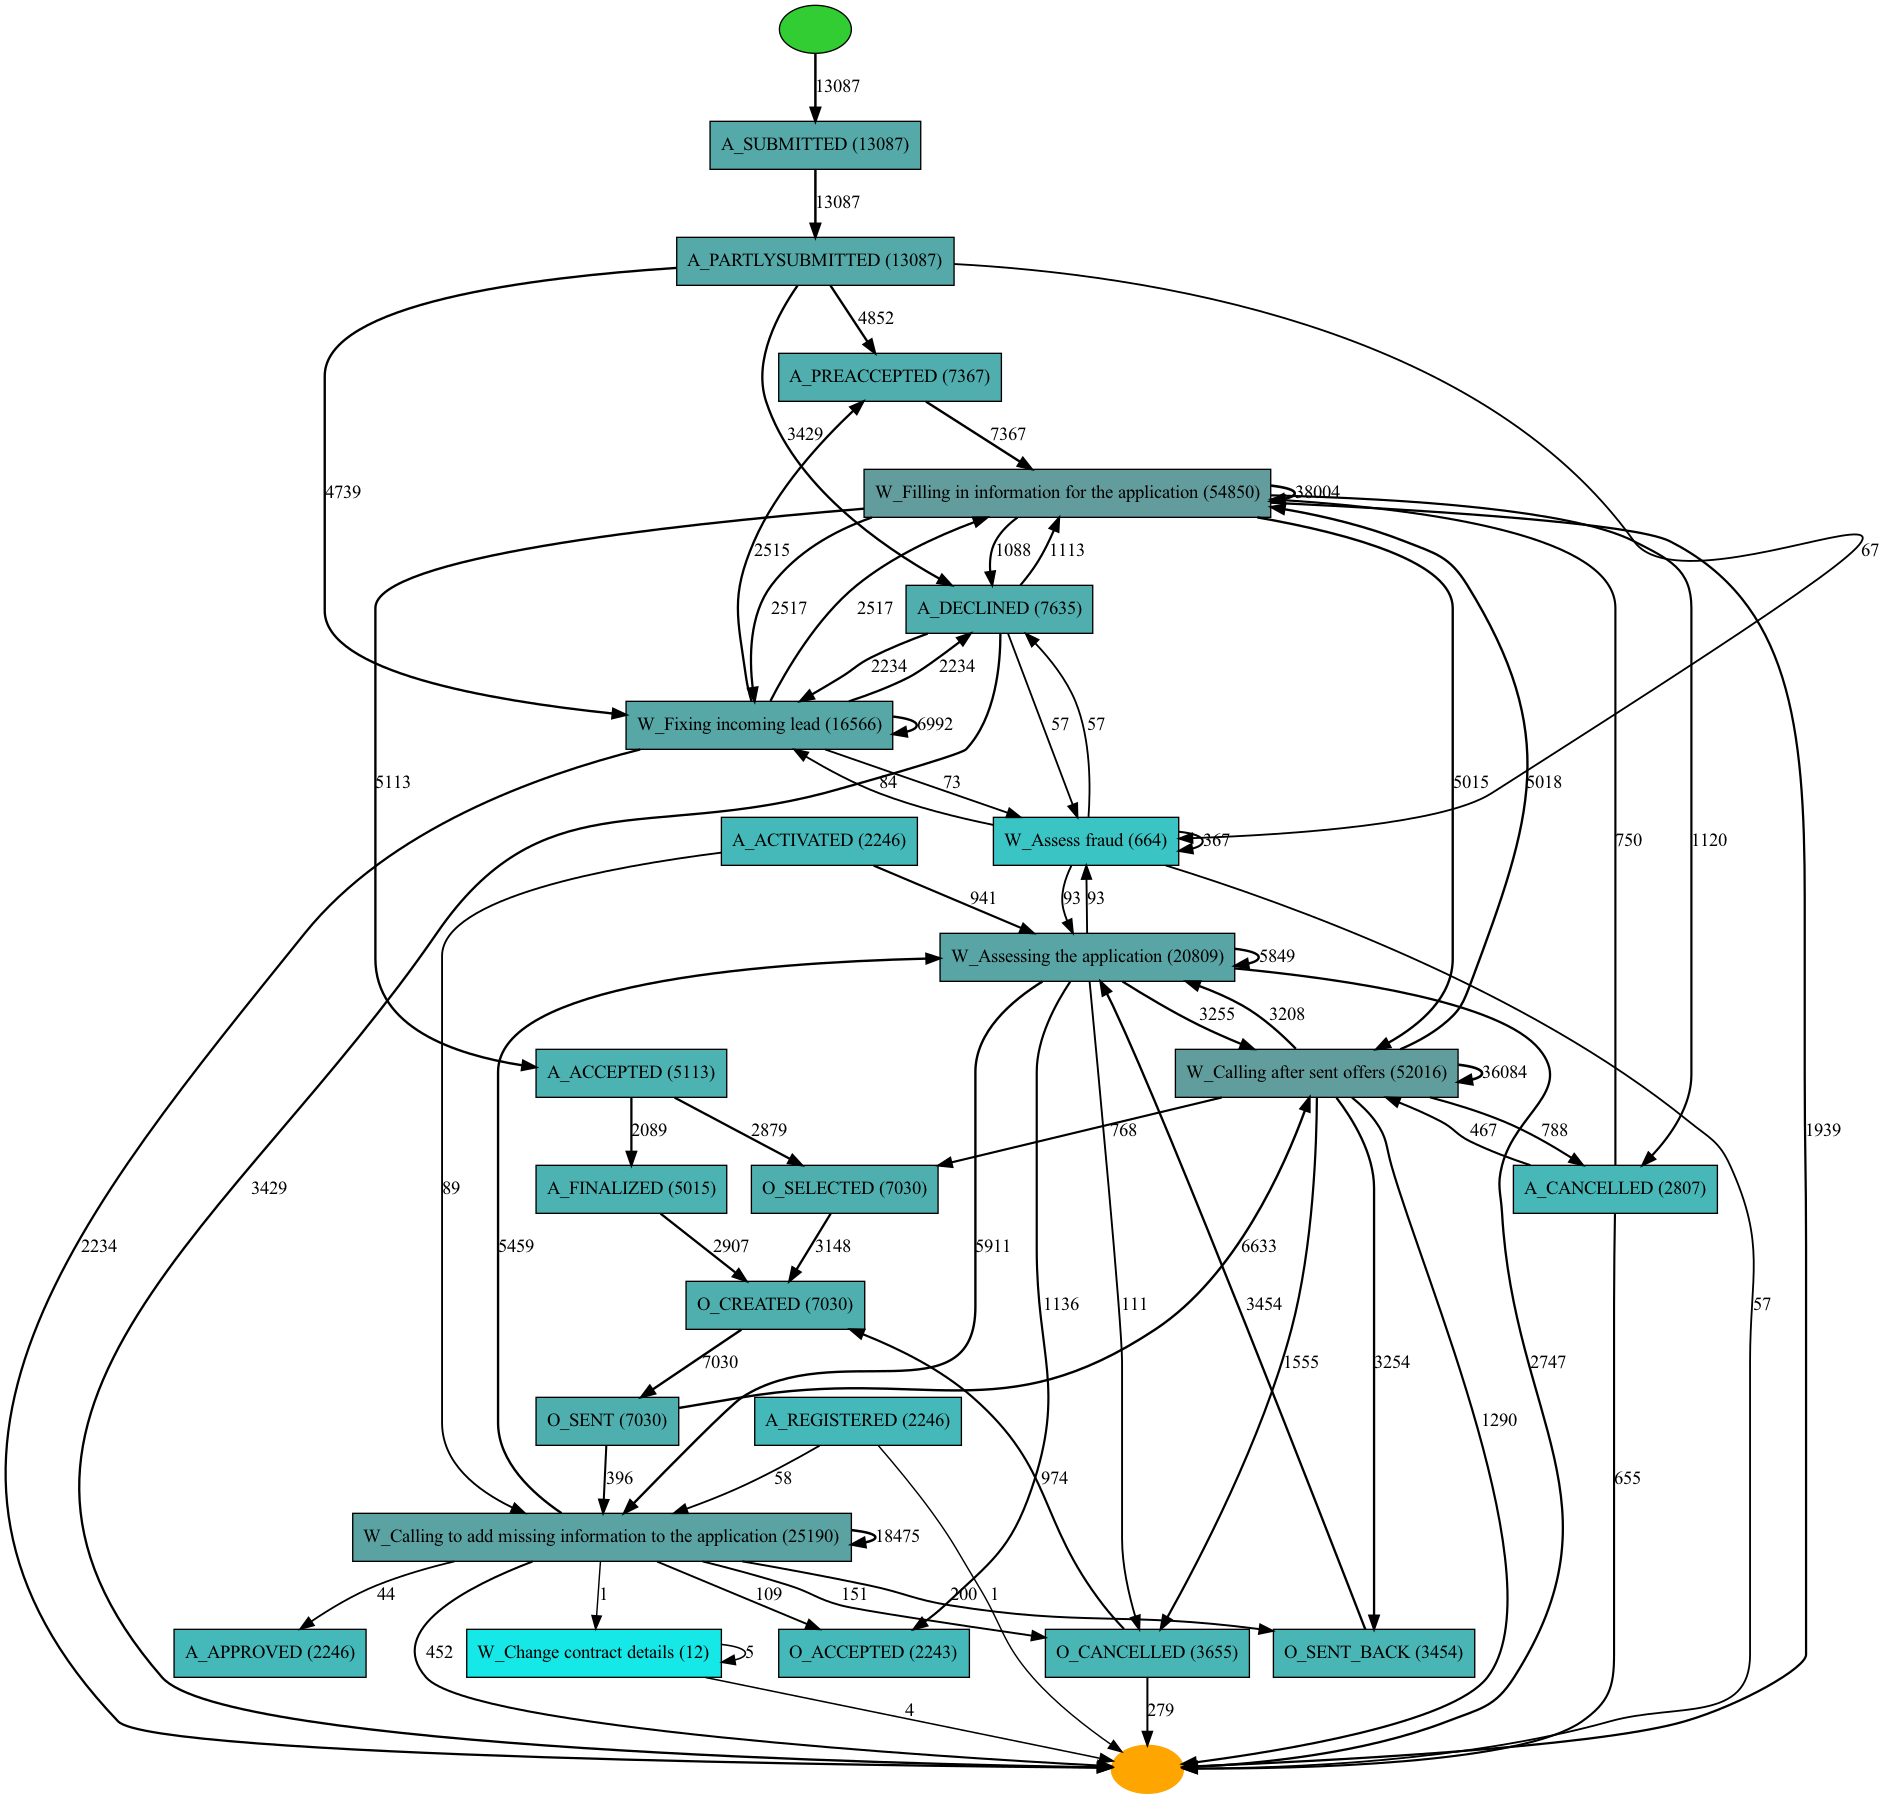

In [56]:
loan_heu = heuristics_miner.apply_heu(event_log_xes)

gviz = hn_visualizer.apply(loan_heu)
hn_visualizer.view(gviz)

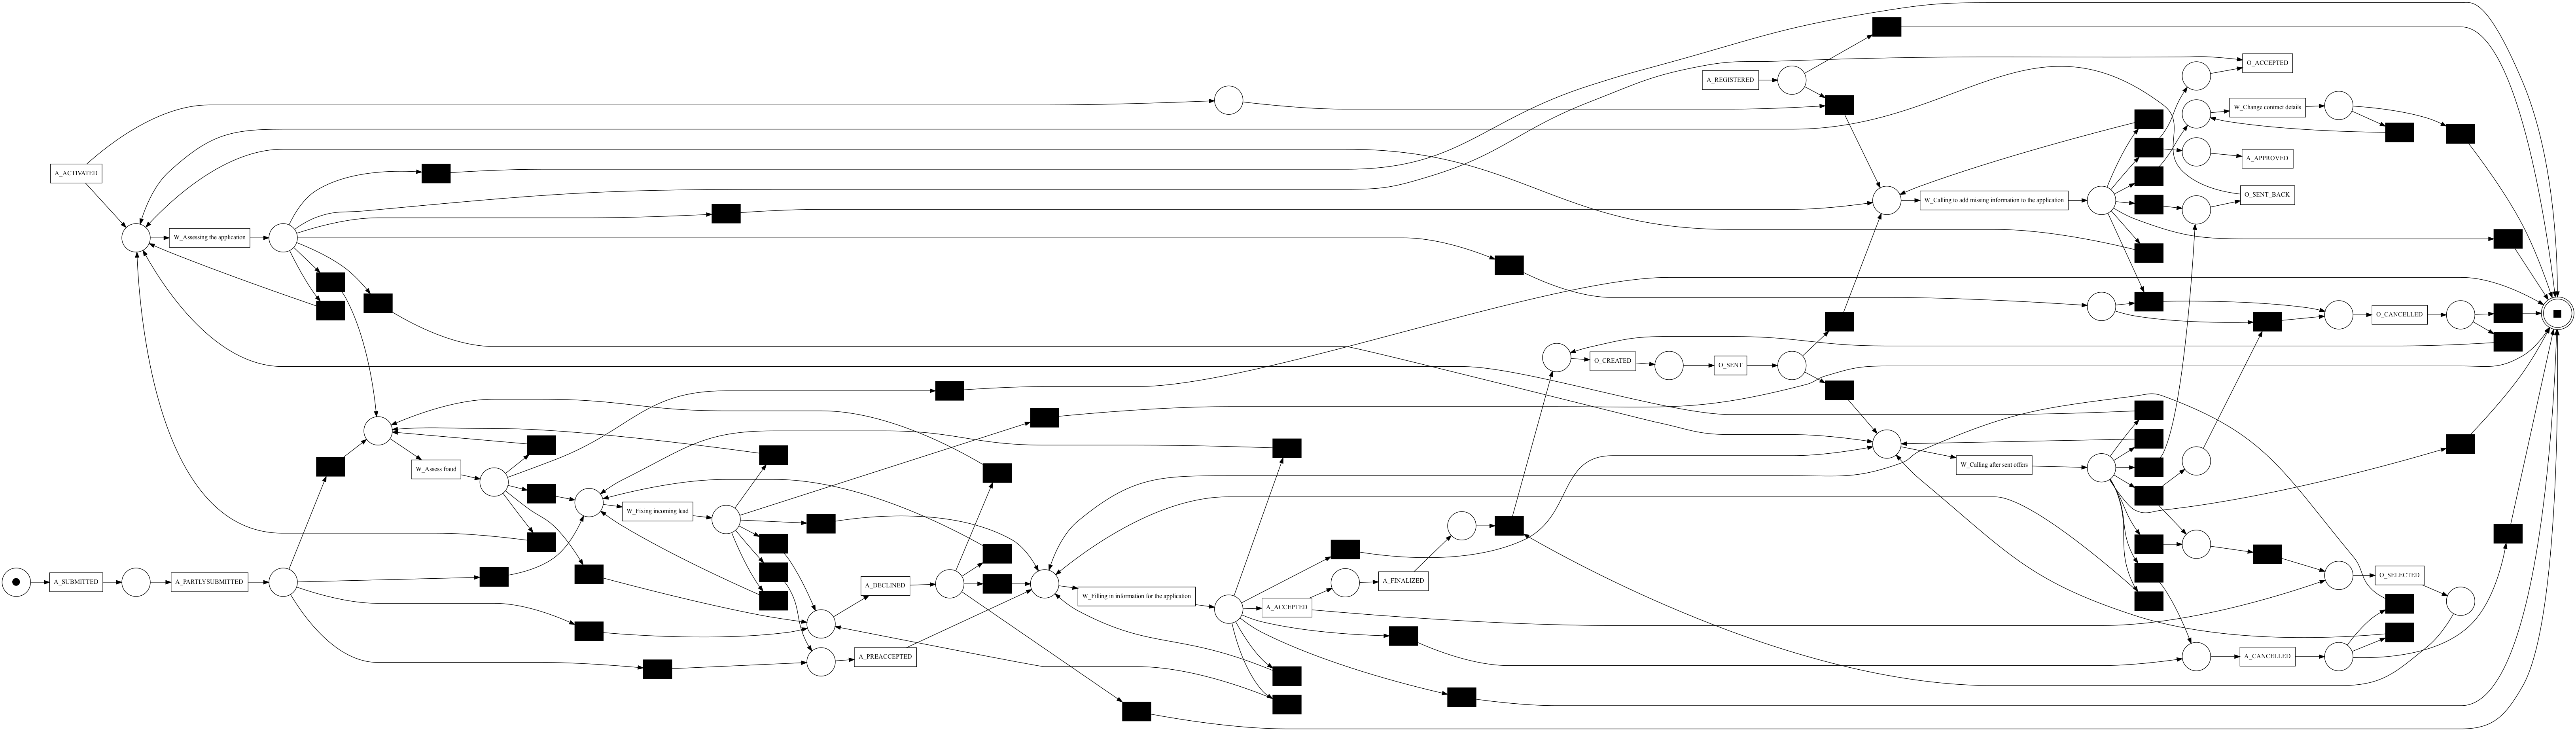

In [57]:
# Visualising Heuristic Minder as Petri Net

net2, im2, fm2= heuristics_miner.apply(event_log_xes)

gviz = pn_visualizer.apply(net2, im2, fm2, log=event_log_xes)
pn_visualizer.view(gviz)

 ### Discovery of Application Status- Alpha Miner

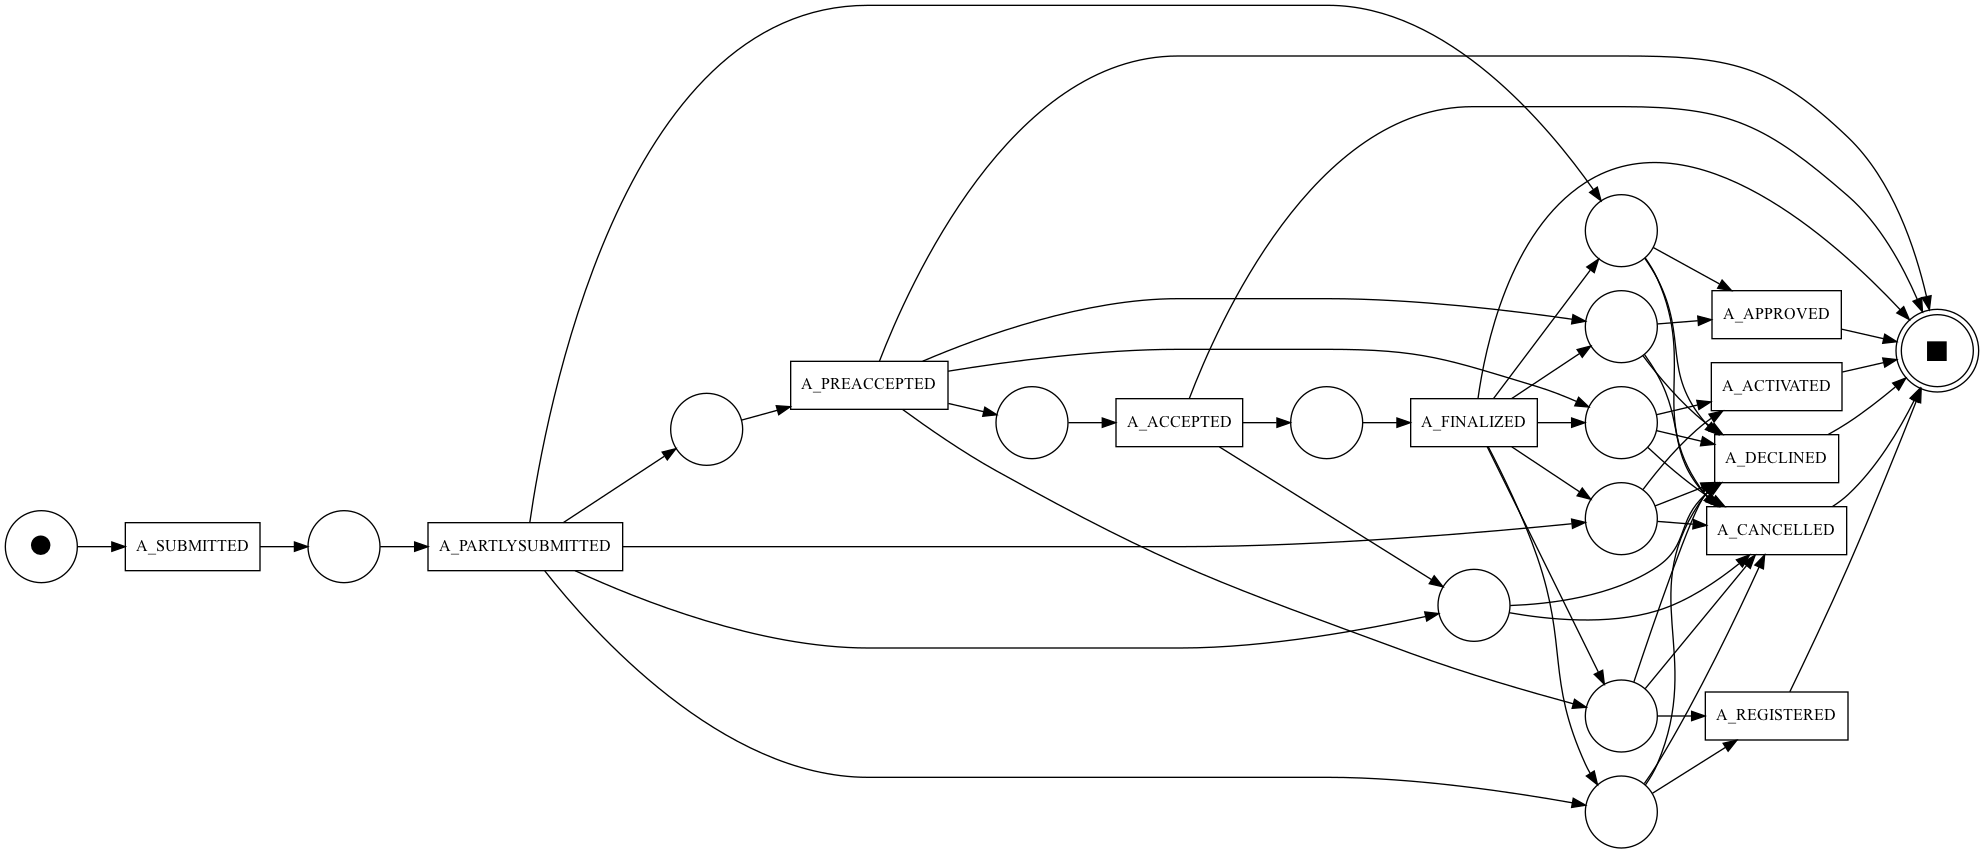

In [58]:
# Applying Alpha Miner Discovery Algorithm and visualising the process model

net3, im3, fm3 = alpha_miner.apply(app_status_log)

gviz = pn_visualizer.apply(net3, im3, fm3, log=app_status_log)
pn_visualizer.view(gviz)


### Discovery of Application Status - Inductive Miner

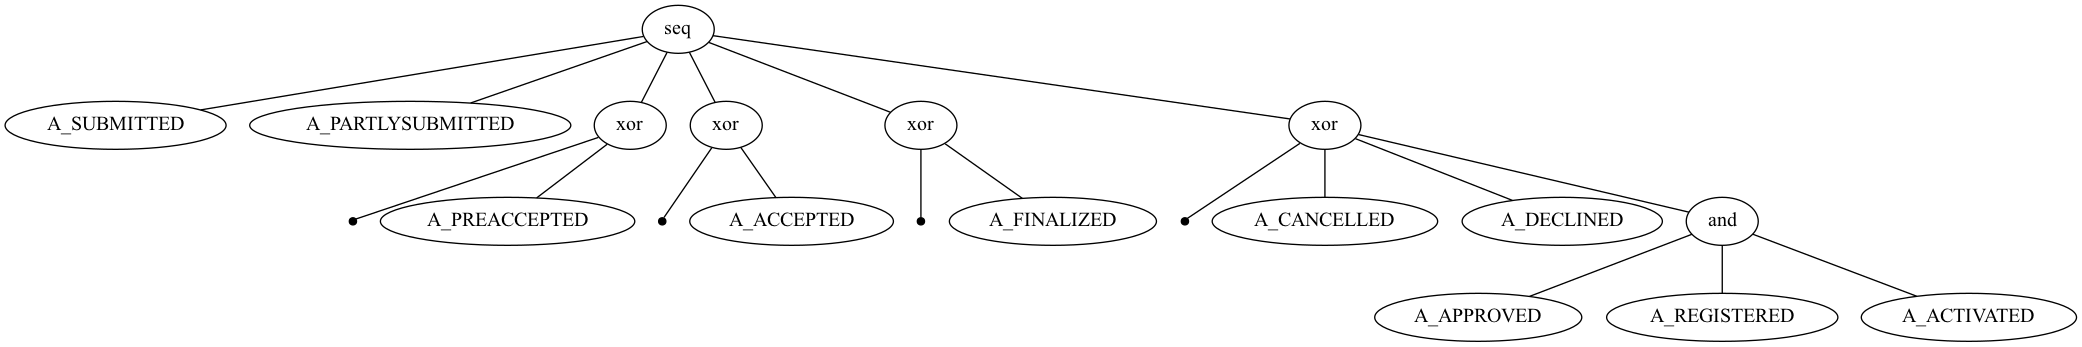

In [59]:
# Applying Inductive Miner Discovery Algorithm and visualising the process model using process tree

app_status_process_tree = inductive_miner.apply_tree(app_status_log)

gviz = pt_visualizer.apply(app_status_process_tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)


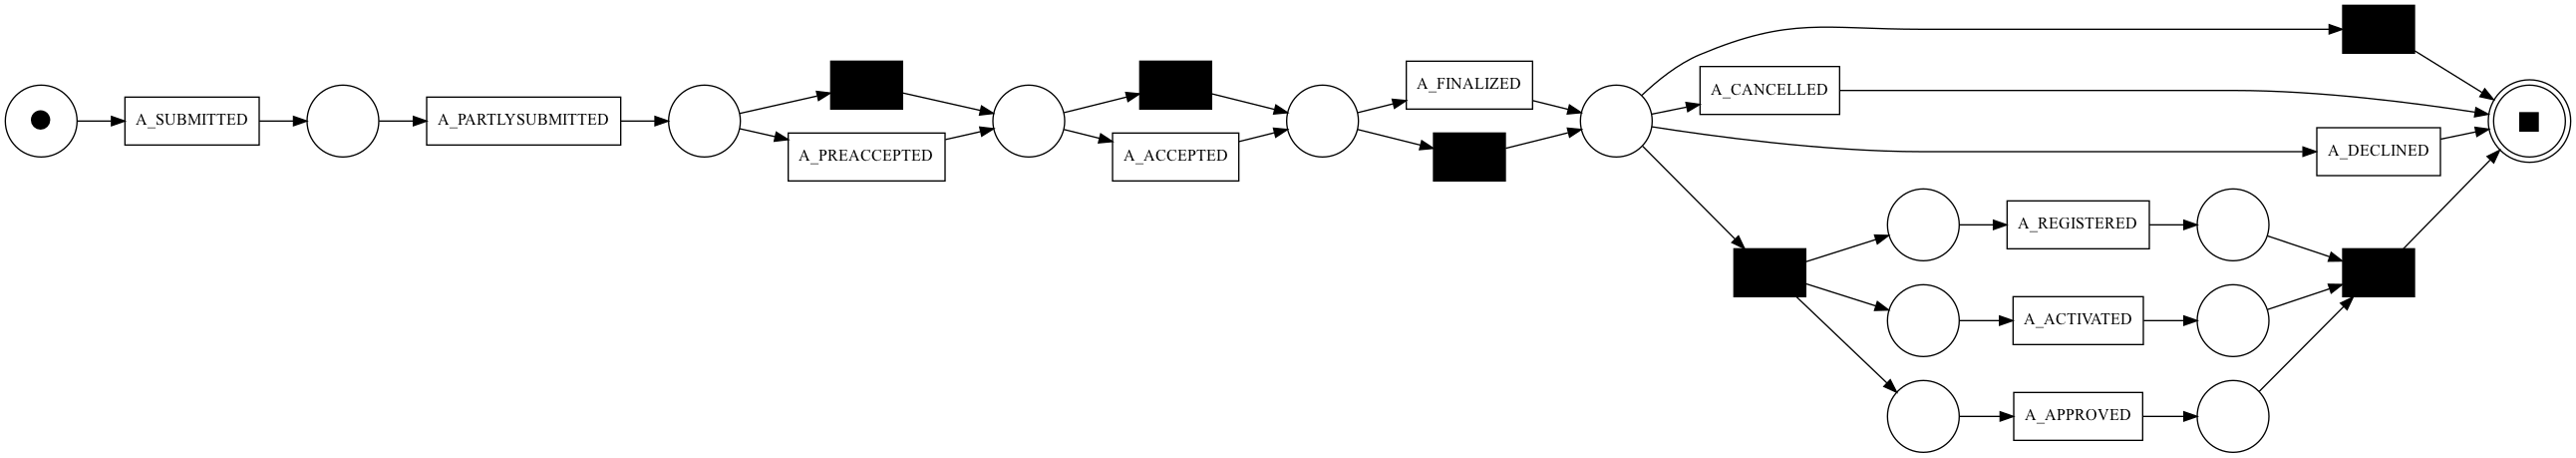

In [60]:
# Converting the Process Tree to Petri-net

net4, im4, fm4 = pt_converter.apply(app_status_process_tree)
gviz = pn_visualizer.apply(net4, im4, fm4,
                           log=app_status_log,parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pn_visualizer.view(gviz)



### Discovery of Application Status - Direct Flow Graphs (DFG) Miner

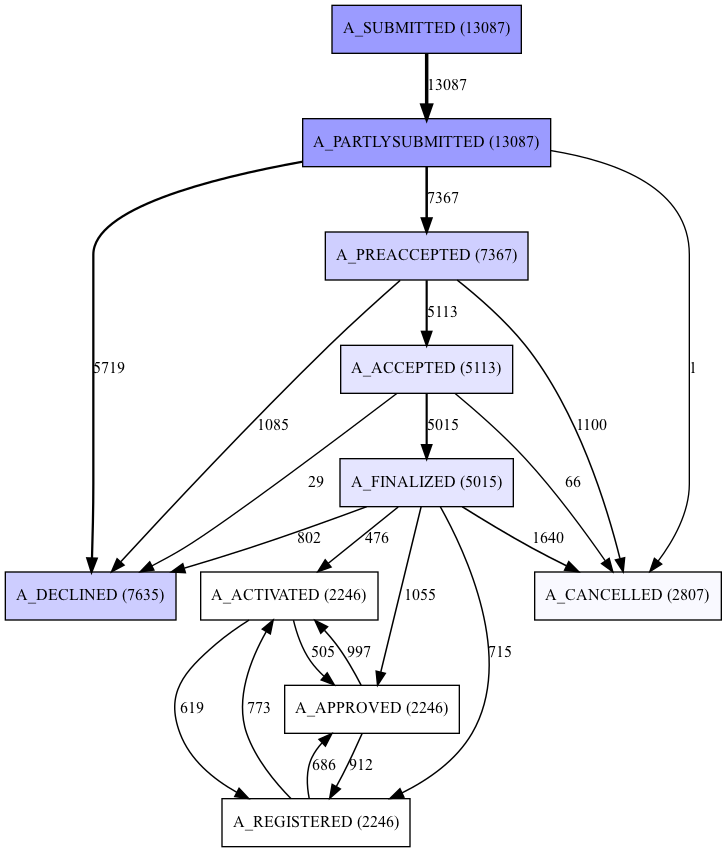

In [61]:
app_status_process_dfg = dfg_discovery.apply(app_status_log)

gviz = dfg_visualization.apply(app_status_process_dfg, log=app_status_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)


### Discovery of Application Status - Heuristic Miner

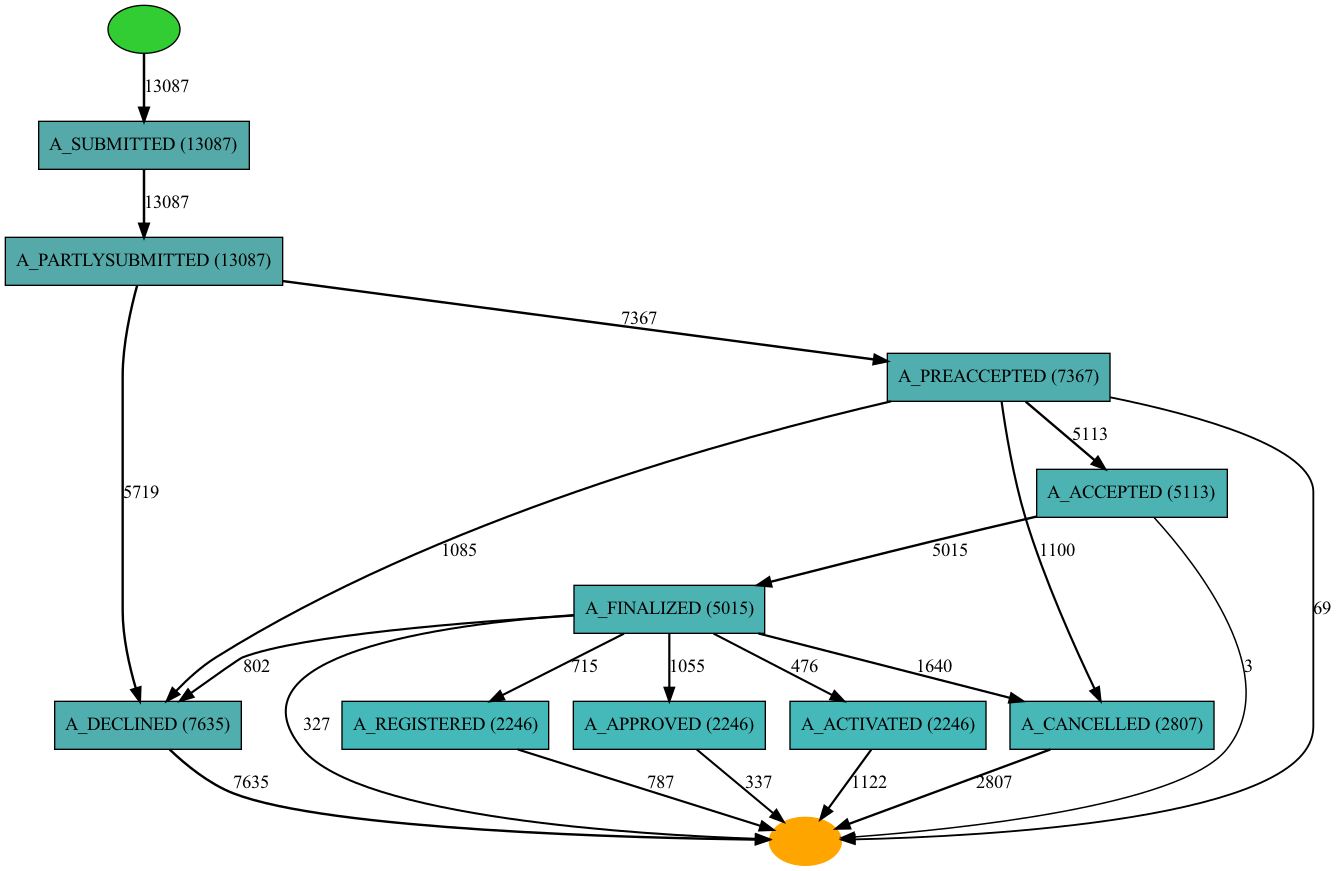

In [62]:
app_status_heu = heuristics_miner.apply_heu(app_status_log)

gviz = hn_visualizer.apply(app_status_heu)
hn_visualizer.view(gviz)


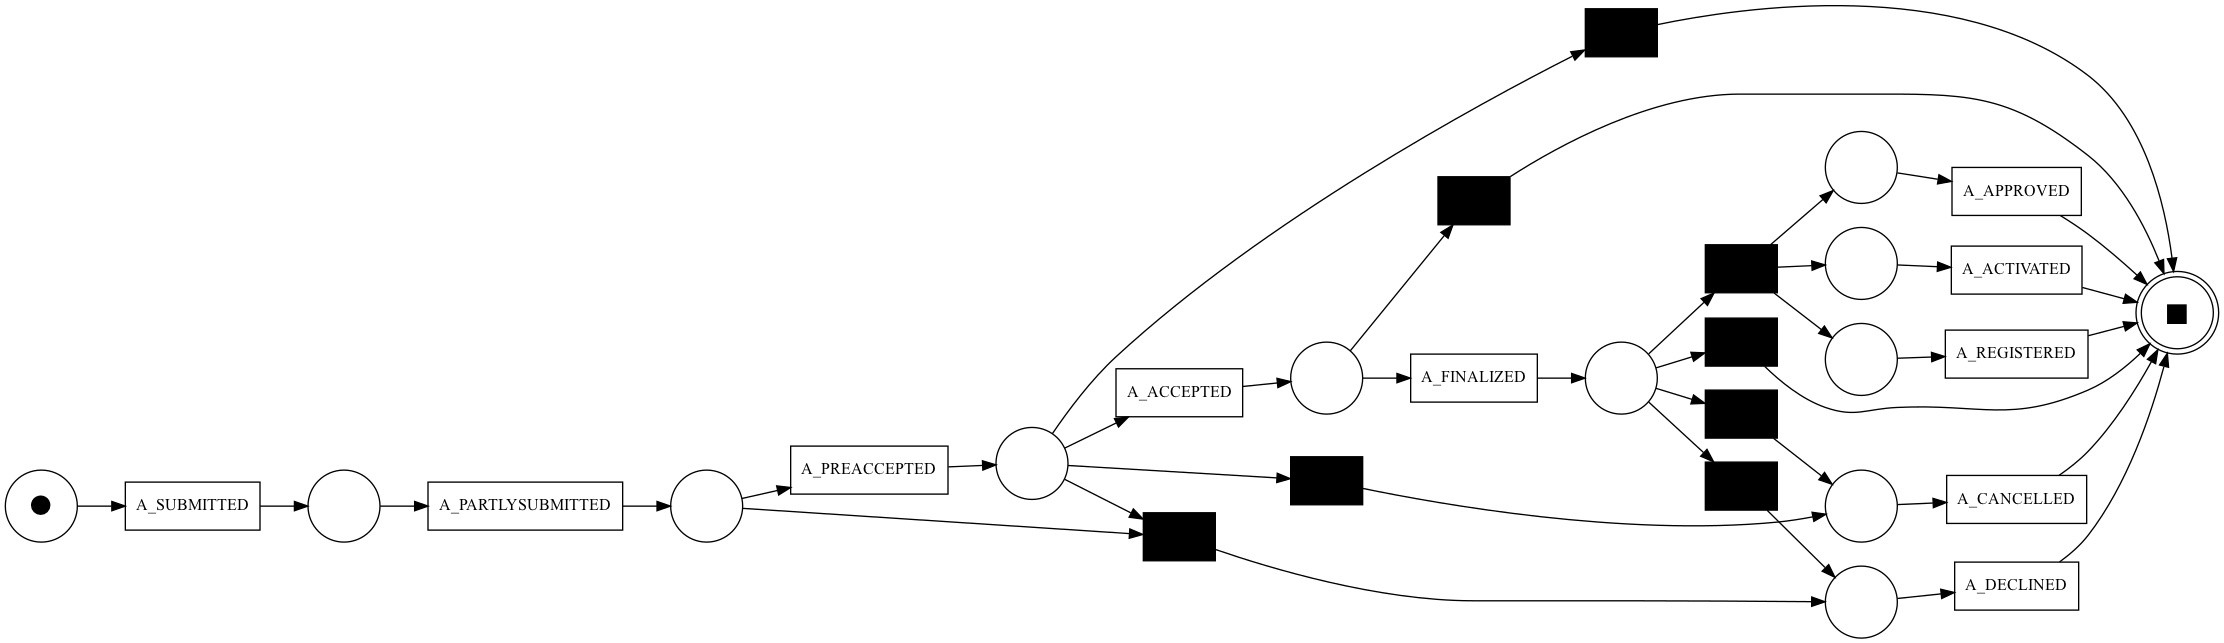

In [63]:

# Visualising Heuristic Minder as Petri Net

net5, im5, fm5= heuristics_miner.apply(app_status_log)

gviz = pn_visualizer.apply(net5, im5, fm5, log=app_status_log)
pn_visualizer.view(gviz)


### Discovery of Offer Status- Alpha Miner

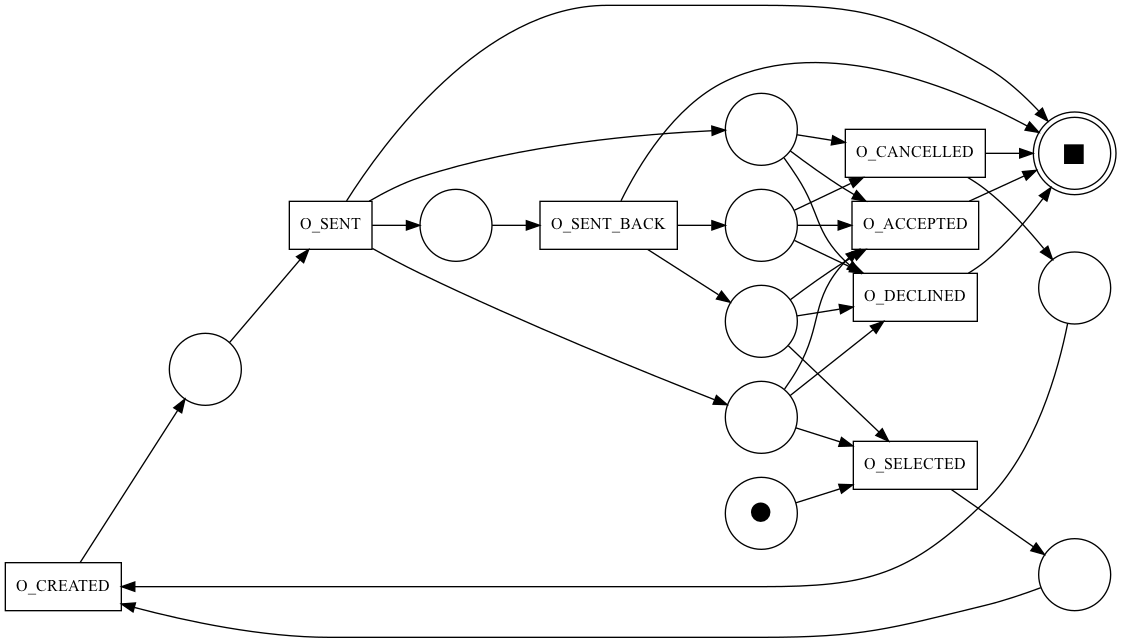

In [64]:
# Applying Alpha Miner Discovery Algorithm and visualising the process model

net6, im6, fm6 = alpha_miner.apply(offer_status_log)

gviz = pn_visualizer.apply(net6, im6, fm6, log=offer_status_log)
pn_visualizer.view(gviz)


### Discovery of Offer Status - Inductive Miner

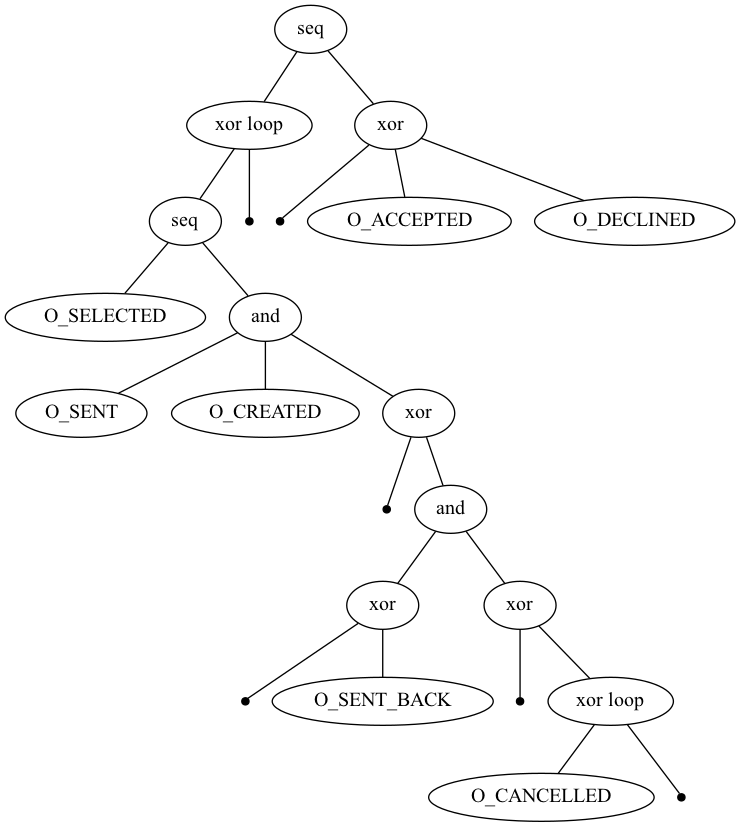

In [65]:
# Applying Inductive Miner Discovery Algorithm and visualising the process model using process tree

offer_status_process_tree = inductive_miner.apply_tree(offer_status_log)

gviz = pt_visualizer.apply(offer_status_process_tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)


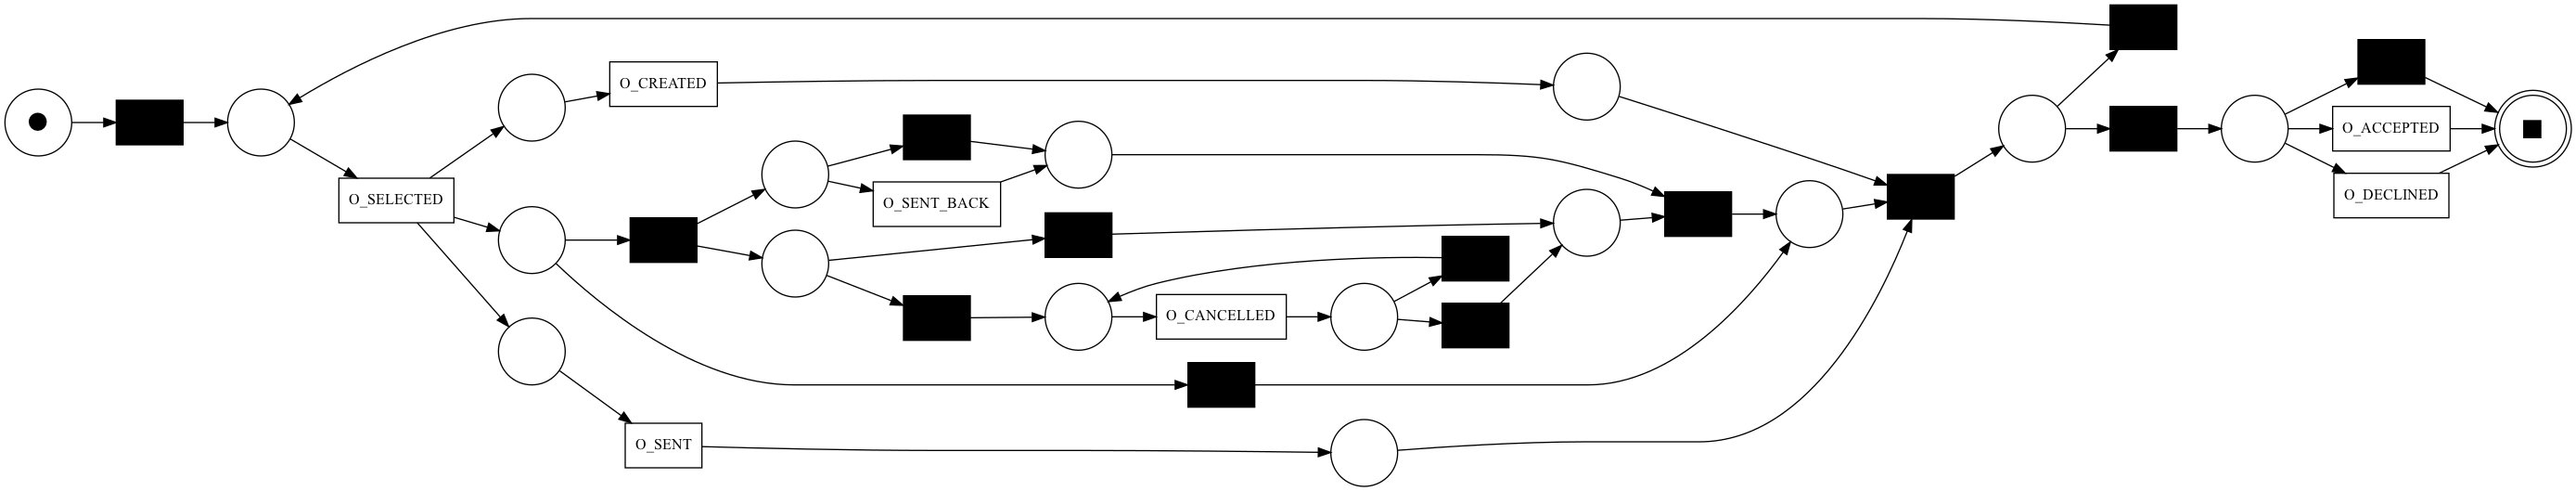

In [66]:
# Converting the Process Tree to Petri-net

net7, im7, fm7 = pt_converter.apply(offer_status_process_tree)
gviz = pn_visualizer.apply(net7, im7, fm7,
                           log=offer_status_log,parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pn_visualizer.view(gviz)


### Discovery of Offer Status - Direct Flow Graphs (DFG) Miner

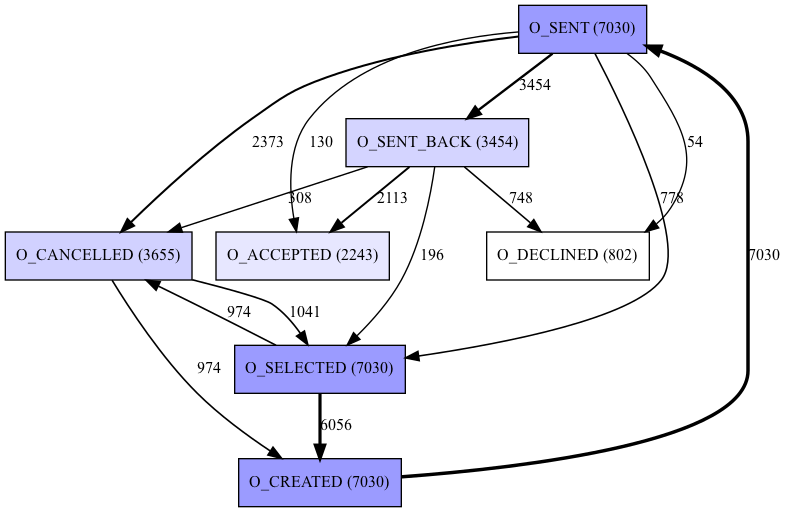

In [67]:
offer_status_process_dfg = dfg_discovery.apply(offer_status_log)

gviz = dfg_visualization.apply(offer_status_process_dfg, log=offer_status_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)


### Discovery of Offer Status - Heuristic Miner

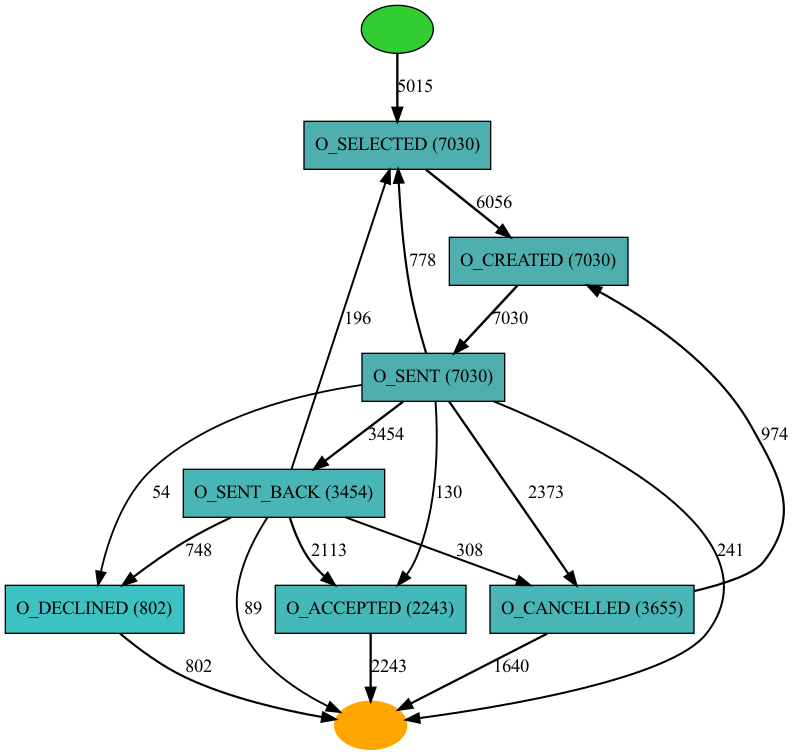

In [68]:
offer_status_heu = heuristics_miner.apply_heu(offer_status_log)

gviz = hn_visualizer.apply(offer_status_heu)
hn_visualizer.view(gviz)


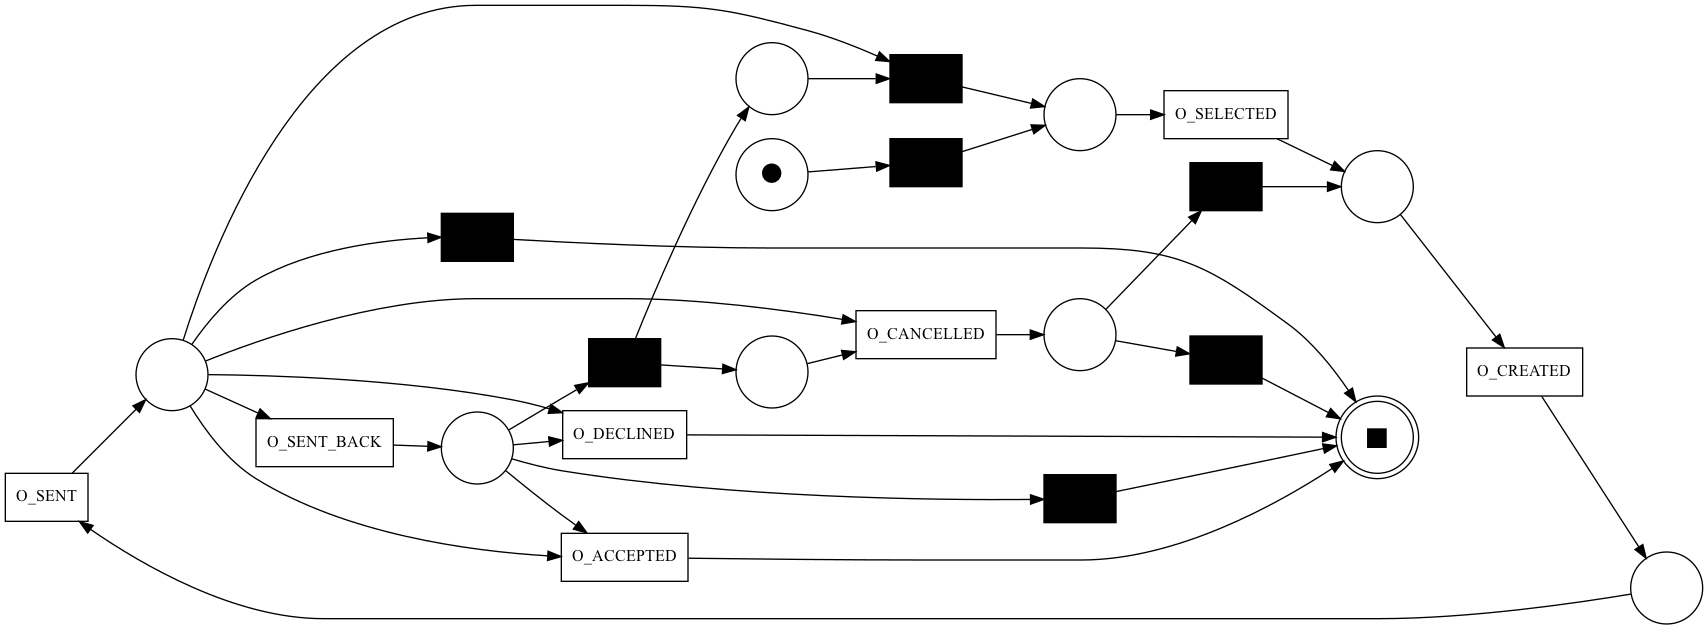

In [69]:
# Visualising Heuristic Minder as Petri Net

net8, im8, fm8= heuristics_miner.apply(offer_status_log)

gviz = pn_visualizer.apply(net8, im8, fm8, log=offer_status_log)
pn_visualizer.view(gviz)


### Discovery of Workitem Status- Alpha Miner

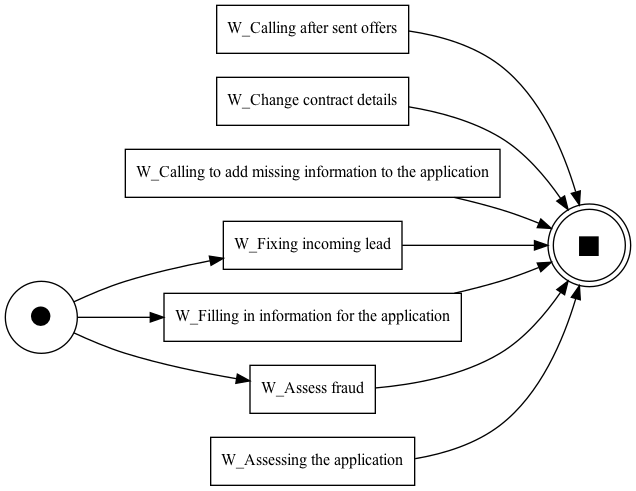

In [70]:
# Applying Alpha Miner Discovery Algorithm and visualising the process model

net9, im9, fm9 = alpha_miner.apply(workitem_status_log)

gviz = pn_visualizer.apply(net9, im9, fm9, log=workitem_status_log)
pn_visualizer.view(gviz)


### Discovery of Workitem Status - Inductive Miner

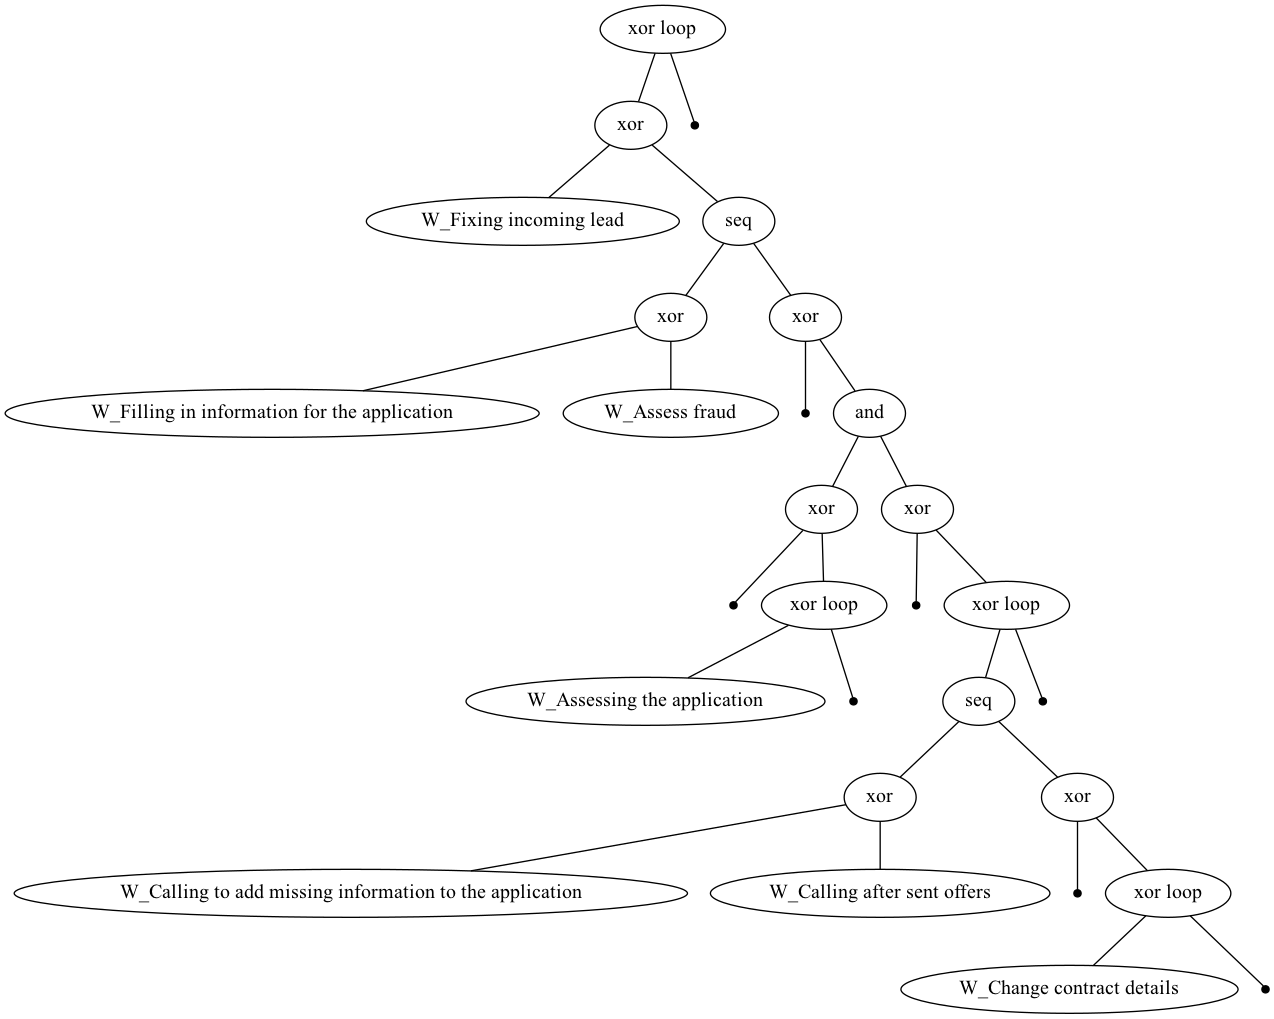

In [71]:
# Applying Inductive Miner Discovery Algorithm and visualising the process model using process tree

workitem_status_process_tree = inductive_miner.apply_tree(workitem_status_log)

gviz = pt_visualizer.apply(workitem_status_process_tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)


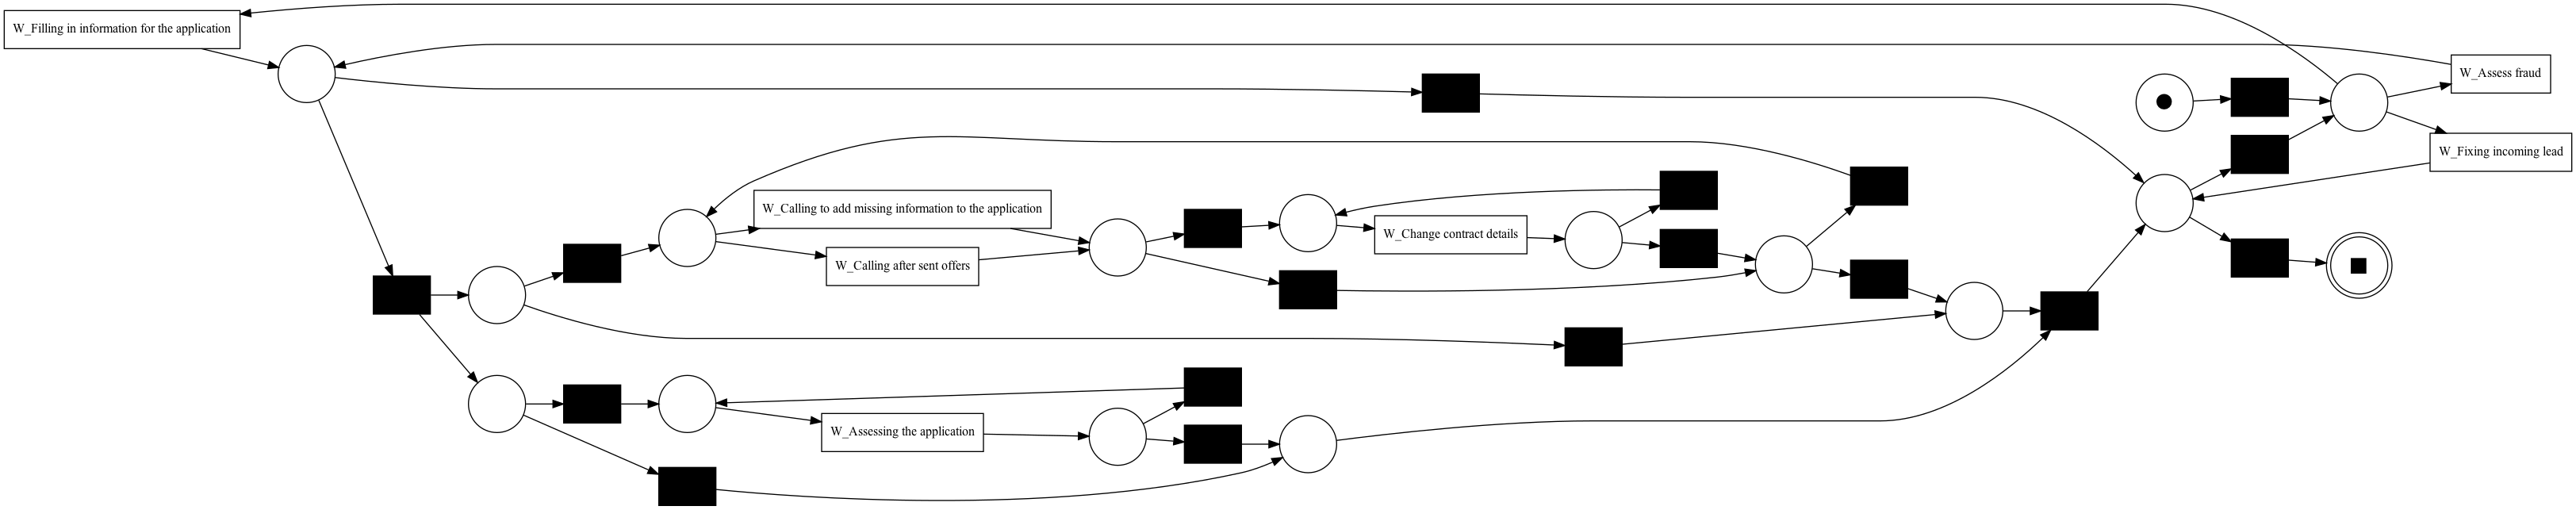

In [72]:
# Converting the Process Tree to Petri-net

net10, im10, fm10 = pt_converter.apply(workitem_status_process_tree)
gviz = pn_visualizer.apply(net10, im10, fm10,
                           log=workitem_status_log,parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pn_visualizer.view(gviz)


### Discovery of Workitem Status - Direct Flow Graphs (DFG) Miner

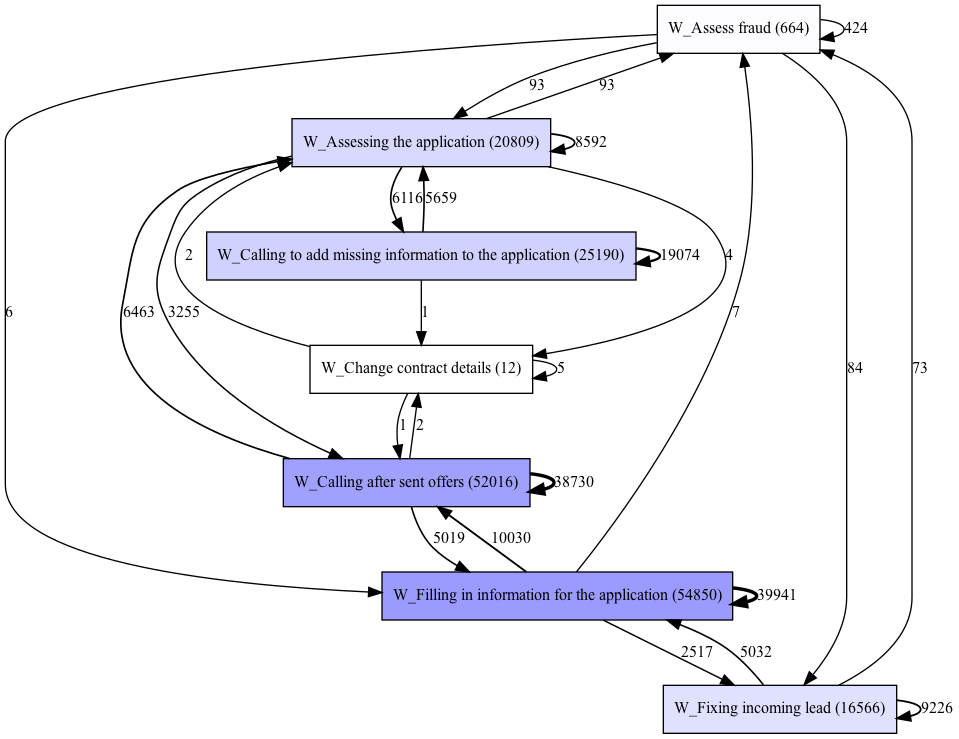

In [73]:
workitem_status_process_dfg = dfg_discovery.apply(workitem_status_log)

gviz = dfg_visualization.apply(workitem_status_process_dfg, log=workitem_status_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)


### Discovery of Workitem Status - Heuristic Miner

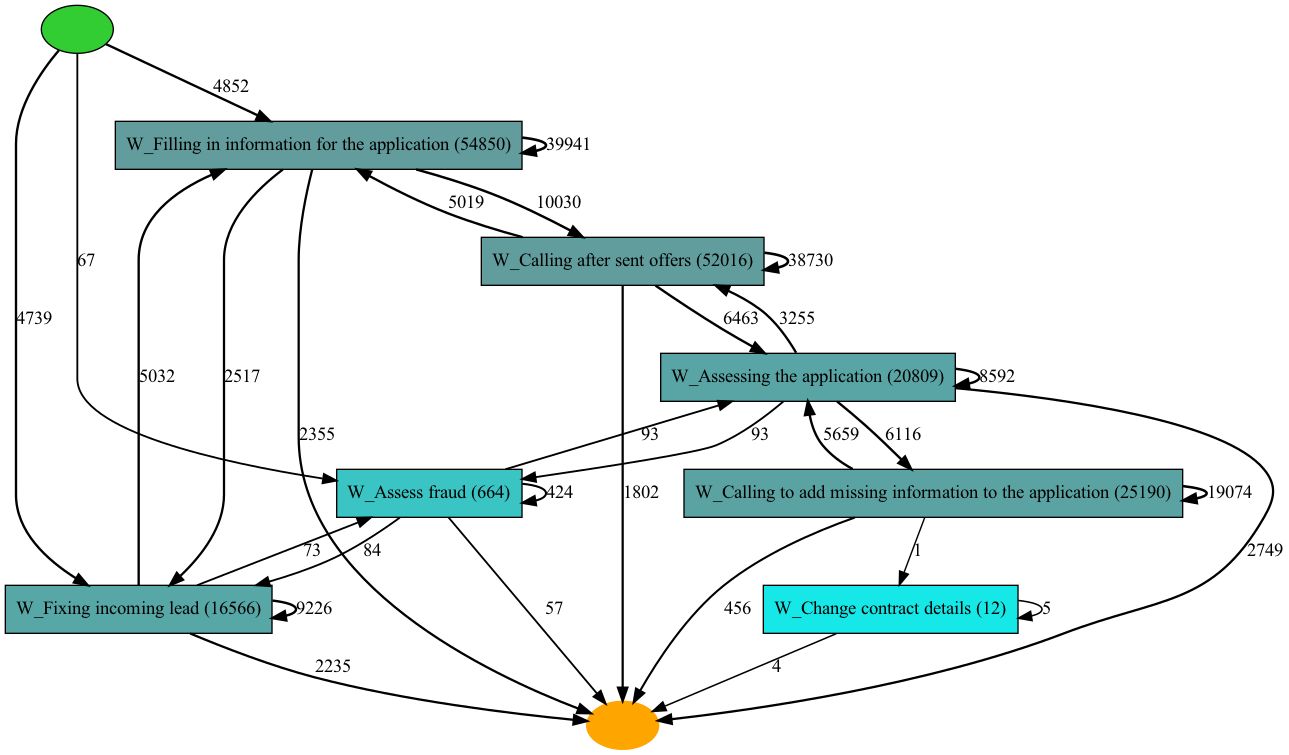

In [74]:
workitem_status_heu = heuristics_miner.apply_heu(workitem_status_log)

gviz = hn_visualizer.apply(workitem_status_heu)
hn_visualizer.view(gviz)



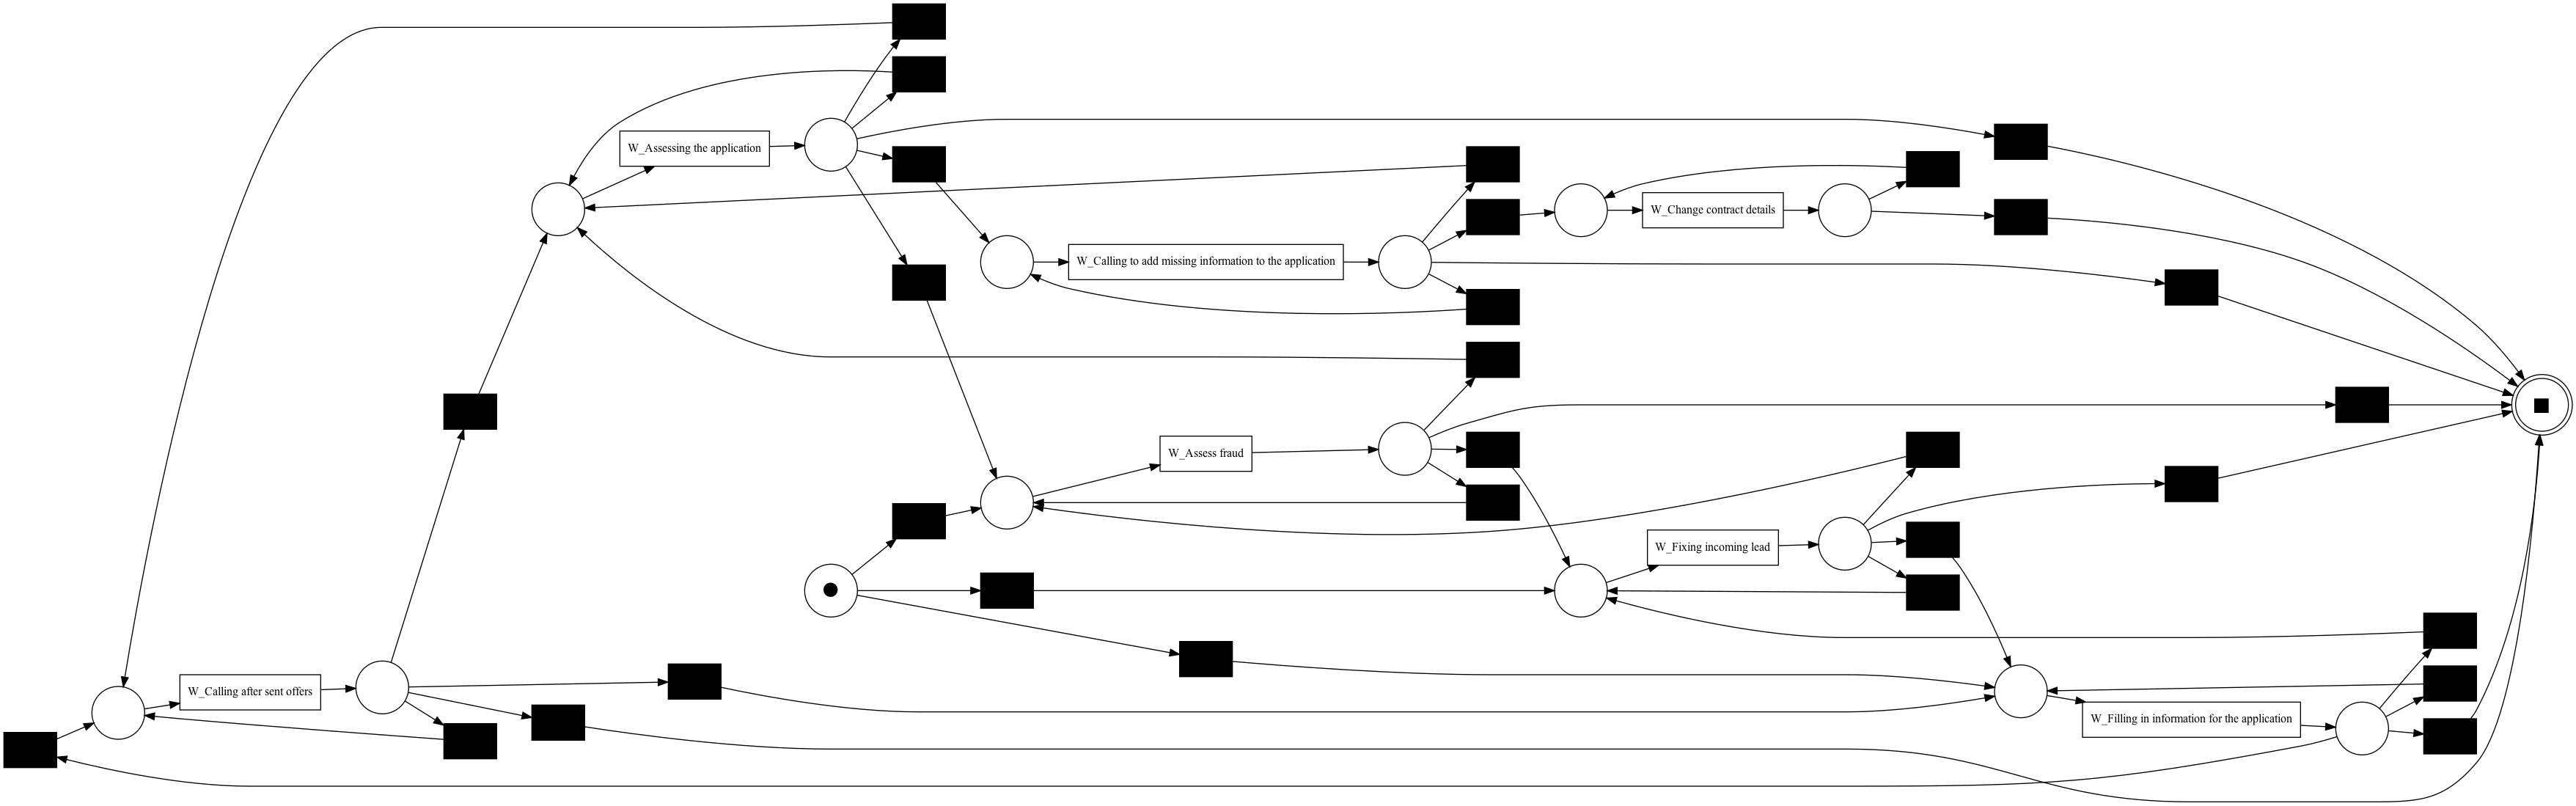

In [75]:
# Visualising Heuristic Minder as Petri Net

net11, im11, fm11= heuristics_miner.apply(workitem_status_log)

gviz = pn_visualizer.apply(net11, im11, fm11, log=workitem_status_log)
pn_visualizer.view(gviz)


## Performing Conformance Techniques
### Conformance of Overall Loan Process- Alpha Miner

In [76]:
# Checking for Fitness, Precision, Generalisation and Simplicity

overall_loan_alpha_fitness_score = replay_fitness_evaluator.apply(event_log_xes, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

overall_loan_alpha_precision_score = precision_evaluator.apply(event_log_xes, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

overall_loan_alpha_generalisation_score = generalization_evaluator.apply(event_log_xes, net, im, fm)

overall_loan_alpha_simplicity_score = simplicity_evaluator.apply(net)

print("Overall Loan Process Fitness score in Alpha miner is :",overall_loan_alpha_fitness_score)
print("Overall Loan Process Precision score in Alpha miner is :",overall_loan_alpha_precision_score)
print("Overall Loan Process Generalisation score in Alpha miner is :",overall_loan_alpha_generalisation_score)
print("Overall Loan Process Simplicity score in Alpha miner is :",overall_loan_alpha_simplicity_score)

replaying log with TBR, completed variants ::   0%|          | 0/4366 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56841 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4366 [00:00<?, ?it/s]

Overall Loan Process Fitness score in Alpha miner is : {'perc_fit_traces': 26.201574081149232, 'average_trace_fitness': 0.7740392525788016, 'log_fitness': 0.6722947077240501, 'percentage_of_fitting_traces': 26.201574081149232}
Overall Loan Process Precision score in Alpha miner is : 0.10239724412318274
Overall Loan Process Generalisation score in Alpha miner is : 0.9735932409545103
Overall Loan Process Simplicity score in Alpha miner is : 0.891891891891892


### Conformance of Application Status- Alpha Miner

In [77]:
# Checking for Fitness, Precision, Generalisation and Simplicity

app_status_alpha_fitness_score = replay_fitness_evaluator.apply(app_status_log, net3, im3, fm3, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

app_status_alpha_precision_score = precision_evaluator.apply(app_status_log, net3, im3, fm3, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

app_status_alpha_generalisation_score = generalization_evaluator.apply(app_status_log, net3, im3, fm3)

app_status_alpha_simplicity_score = simplicity_evaluator.apply(net3)

print("Application Status Process Fitness score in Alpha miner is :",app_status_alpha_fitness_score)
print("Application Status Process Precision score in Alpha miner is :",app_status_alpha_precision_score)
print("Application Status Process Generalisation score in Alpha miner is :",app_status_alpha_generalisation_score)
print("Application Status Process Simplicity score in Alpha miner is :",app_status_alpha_simplicity_score)


replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

Application Status Process Fitness score in Alpha miner is : {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.7972651807745887, 'log_fitness': 0.761876888688735, 'percentage_of_fitting_traces': 0.0}
Application Status Process Precision score in Alpha miner is : 0.6682768515559899
Application Status Process Generalisation score in Alpha miner is : 0.9849139556688847
Application Status Process Simplicity score in Alpha miner is : 0.2911392405063291


### Conformance of Offer Status Process- Alpha Miner

In [78]:
# Checking for Fitness, Precision, Generalisation and Simplicity

offer_status_alpha_fitness_score = replay_fitness_evaluator.apply(offer_status_log, net6, im6, fm6, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

offer_status_alpha_precision_score = precision_evaluator.apply(offer_status_log, net6, im6, fm6, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

offer_status_alpha_generalisation_score = generalization_evaluator.apply(offer_status_log, net6, im6, fm6)

offer_status_alpha_simplicity_score = simplicity_evaluator.apply(net6)

print("Offer Status Process Fitness score in Alpha miner is :",offer_status_alpha_fitness_score)
print("Offer Status Process Precision score in Alpha miner is :",offer_status_alpha_precision_score)
print("Offer Status Process Generalisation score in Alpha miner is :",offer_status_alpha_generalisation_score)
print("Offer Status Process Simplicity score in Alpha miner is :",offer_status_alpha_simplicity_score)


replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/411 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

Offer Status Process Fitness score in Alpha miner is : {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.6890303174678584, 'log_fitness': 0.6943154596373059, 'percentage_of_fitting_traces': 0.0}
Offer Status Process Precision score in Alpha miner is : 1.0
Offer Status Process Generalisation score in Alpha miner is : 0.9820339600726753
Offer Status Process Simplicity score in Alpha miner is : 0.39534883720930236


### Conformance of Workitem Status Process- Alpha Miner

In [79]:
# Checking for Fitness, Precision, Generalisation and Simplicity

workitem_status_alpha_fitness_score = replay_fitness_evaluator.apply(workitem_status_log, net9, im9, fm9, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

workitem_status_alpha_precision_score = precision_evaluator.apply(workitem_status_log, net9, im9, fm9, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

workitem_status_alpha_generalisation_score = generalization_evaluator.apply(workitem_status_log, net9, im9, fm9)

workitem_status_alpha_simplicity_score = simplicity_evaluator.apply(net9)

print("Workitem Status Process Fitness score in Alpha miner is :",workitem_status_alpha_fitness_score)
print("Workitem Status Process Precision score in Alpha miner is :",workitem_status_alpha_precision_score)
print("Workitem Status Process Generalisation score in Alpha miner is :",workitem_status_alpha_generalisation_score)
print("Workitem Status Process Simplicity score in Alpha miner is :",workitem_status_alpha_simplicity_score)


replaying log with TBR, completed variants ::   0%|          | 0/2643 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/26423 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2643 [00:00<?, ?it/s]

Workitem Status Process Fitness score in Alpha miner is : {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.27484851486754003, 'log_fitness': 0.17188371451728185, 'percentage_of_fitting_traces': 0.0}
Workitem Status Process Precision score in Alpha miner is : 0.2727272727272727
Workitem Status Process Generalisation score in Alpha miner is : 0.9489800722443816
Workitem Status Process Simplicity score in Alpha miner is : 0.8181818181818181


### Conformance of Overall Loan Process- Inductive Miner

In [80]:
# Checking for Fitness, Precision, Generalisation and Simplicity

overall_loan_inductive_fitness_score = replay_fitness_evaluator.apply(event_log_xes, net1, im1, fm1, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

overall_loan_inductive_precision_score = precision_evaluator.apply(event_log_xes, net1, im1, fm1, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

overall_loan_inductive_generalisation_score = generalization_evaluator.apply(event_log_xes, net1, im1, fm1)

overall_loan_inductive_simplicity_score = simplicity_evaluator.apply(net1)


print("Overall Loan Process Fitness score in Inductive miner is :",overall_loan_inductive_fitness_score)
print("Overall Loan Process Precision score in Inductive miner is :",overall_loan_inductive_precision_score)
print("Overall Loan Process Generalisation score in Inductive miner is :",overall_loan_inductive_generalisation_score)
print("Overall Loan Process Simplicity score in Inductive miner is :",overall_loan_inductive_simplicity_score)



replaying log with TBR, completed variants ::   0%|          | 0/4366 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56841 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4366 [00:00<?, ?it/s]

Overall Loan Process Fitness score in Inductive miner is : {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Overall Loan Process Precision score in Inductive miner is : 0.11614605584800297
Overall Loan Process Generalisation score in Inductive miner is : 0.9614268998755126
Overall Loan Process Simplicity score in Inductive miner is : 0.5609756097560976


### Conformance of Apllication Status Process- Inductive Miner

In [81]:
# Checking for Fitness, Precision, Generalisation and Simplicity

app_status_inductive_fitness_score = replay_fitness_evaluator.apply(app_status_log, net4, im4, fm4, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

app_status_inductive_precision_score = precision_evaluator.apply(app_status_log, net4, im4, fm4, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

app_status_inductive_generalisation_score = generalization_evaluator.apply(app_status_log, net4, im4, fm4)

app_status_inductive_simplicity_score = simplicity_evaluator.apply(net4)


print("Application Status Process Fitness score in Inductive miner is :",app_status_inductive_fitness_score)
print("Application Status Process Precision score in Inductive miner is :",app_status_inductive_precision_score)
print("Application Status Process Generalisation score in Inductive miner is :",app_status_inductive_generalisation_score)
print("Application Status Process Simplicity score in Inductive miner is :",app_status_inductive_simplicity_score)



replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

Application Status Process Fitness score in Inductive miner is : {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Application Status Process Precision score in Inductive miner is : 0.5471181330675388
Application Status Process Generalisation score in Inductive miner is : 0.9825827902072926
Application Status Process Simplicity score in Inductive miner is : 0.6744186046511628


### Conformance of Offer Status Process- Inductive Miner

In [82]:
# Checking for Fitness, Precision, Generalisation and Simplicity

offer_status_inductive_fitness_score = replay_fitness_evaluator.apply(offer_status_log, net7, im7, fm7, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

offer_status_inductive_precision_score = precision_evaluator.apply(offer_status_log, net7, im7, fm7, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

offer_status_inductive_generalisation_score = generalization_evaluator.apply(offer_status_log, net7, im7, fm7)

offer_status_inductive_simplicity_score = simplicity_evaluator.apply(net7)


print("Offer Status Process Fitness score in Inductive miner is :",offer_status_inductive_fitness_score)
print("Offer Status Process Precision score in Inductive miner is :",offer_status_inductive_precision_score)
print("Offer Status Process Generalisation score in Inductive miner is :",offer_status_inductive_generalisation_score)
print("Offer Status Process Simplicity score in Inductive miner is :",offer_status_inductive_simplicity_score)



replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/411 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

Offer Status Process Fitness score in Inductive miner is : {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
Offer Status Process Precision score in Inductive miner is : 0.5520943568592336
Offer Status Process Generalisation score in Inductive miner is : 0.9802372449160853
Offer Status Process Simplicity score in Inductive miner is : 0.6727272727272727


### Conformance of Workitem Status Process- Inductive Miner

In [83]:
# Checking for Fitness, Precision, Generalisation and Simplicity

workitem_status_inductive_fitness_score = replay_fitness_evaluator.apply(workitem_status_log, net10, im10, fm10, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

workitem_status_inductive_precision_score = precision_evaluator.apply(workitem_status_log, net10, im10, fm10, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

workitem_status_inductive_generalisation_score = generalization_evaluator.apply(workitem_status_log, net10, im10, fm10)

workitem_status_inductive_simplicity_score = simplicity_evaluator.apply(net10)


print("WorkItem Status Process Fitness score in Inductive miner is :",workitem_status_inductive_fitness_score)
print("WorkItem Status Process Precision score in Inductive miner is :",workitem_status_inductive_precision_score)
print("WorkItem Status Process Generalisation score in Inductive miner is :",workitem_status_inductive_generalisation_score)
print("WorkItem Status Process Simplicity score in Inductive miner is :",workitem_status_inductive_simplicity_score)



replaying log with TBR, completed variants ::   0%|          | 0/2643 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/26423 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2643 [00:00<?, ?it/s]

WorkItem Status Process Fitness score in Inductive miner is : {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
WorkItem Status Process Precision score in Inductive miner is : 0.2969224995725386
WorkItem Status Process Generalisation score in Inductive miner is : 0.9276499337720443
WorkItem Status Process Simplicity score in Inductive miner is : 0.6507936507936508


### Conformance of Overall Loan Process- Heuristic Miner

In [84]:
# Checking for Fitness, Precision, Generalisation and Simplicity

overall_loan_heuristic_fitness_score = replay_fitness_evaluator.apply(event_log_xes, net2, im2, fm2, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

overall_loan_heuristic_precision_score = precision_evaluator.apply(event_log_xes, net2, im2, fm2, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

overall_loan_heuristic_generalisation_score = generalization_evaluator.apply(event_log_xes, net2, im2, fm2)

overall_loan_heuristic_simplicity_score = simplicity_evaluator.apply(net2)

print("Overall loan Process Fitness score in Heuristic miner is :",overall_loan_heuristic_fitness_score)
print("Overall loan Process Precision score in Heuristic miner is :",overall_loan_heuristic_precision_score)
print("Overall loan Process Generalisation score in Heuristic miner is :",overall_loan_heuristic_generalisation_score)
print("Overall loan Process Simplicity score in Heuristic miner is :",overall_loan_heuristic_simplicity_score)




replaying log with TBR, completed variants ::   0%|          | 0/4366 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/56841 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/4366 [00:00<?, ?it/s]

Overall loan Process Fitness score in Heuristic miner is : {'perc_fit_traces': 62.51241690226943, 'average_trace_fitness': 0.9869616514495677, 'log_fitness': 0.9777192683210958, 'percentage_of_fitting_traces': 62.51241690226943}
Overall loan Process Precision score in Heuristic miner is : 0.31220890274300683
Overall loan Process Generalisation score in Heuristic miner is : 0.9279376526265016
Overall loan Process Simplicity score in Heuristic miner is : 0.5616438356164384


### Conformance of Application Status Process- Heuristic Miner

In [85]:
# Checking for Fitness, Precision, Generalisation and Simplicity

app_status_heuristic_fitness_score = replay_fitness_evaluator.apply(app_status_log, net5, im5, fm5, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

app_status_heuristic_precision_score = precision_evaluator.apply(app_status_log, net5, im5, fm5, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

app_status_heuristic_generalisation_score = generalization_evaluator.apply(app_status_log, net5, im5, fm5)

app_status_heuristic_simplicity_score = simplicity_evaluator.apply(net5)

print("Application Status Process Fitness score in Heuristic miner is :",app_status_heuristic_fitness_score)
print("Application Status Process Precision score in Heuristic miner is :",app_status_heuristic_precision_score)
print("Application Status Process Generalisation score in Heuristic miner is :",app_status_heuristic_generalisation_score)
print("Application Status Process Simplicity score in Heuristic miner is :",app_status_heuristic_simplicity_score)




replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

Application Status Process Fitness score in Heuristic miner is : {'perc_fit_traces': 30.113853442347366, 'average_trace_fitness': 0.8586383433941921, 'log_fitness': 0.8896245332793149, 'percentage_of_fitting_traces': 30.113853442347366}
Application Status Process Precision score in Heuristic miner is : 1.0
Application Status Process Generalisation score in Heuristic miner is : 0.8880470605881805
Application Status Process Simplicity score in Heuristic miner is : 0.625


### Conformance of Offer Status Process- Heuristic Miner

In [86]:
# Checking for Fitness, Precision, Generalisation and Simplicity

offer_status_heuristic_fitness_score = replay_fitness_evaluator.apply(offer_status_log, net8, im8, fm8, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

offer_status_heuristic_precision_score = precision_evaluator.apply(offer_status_log, net8, im8, fm8, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

offer_status_heuristic_generalisation_score = generalization_evaluator.apply(offer_status_log, net8, im8, fm8)

offer_status_heuristic_simplicity_score = simplicity_evaluator.apply(net8)

print("Offer Status Process Fitness score in Heuristic miner is :",offer_status_heuristic_fitness_score)
print("Offer Status Process Precision score in Heuristic miner is :",offer_status_heuristic_precision_score)
print("Offer Status Process Generalisation score in Heuristic miner is :",offer_status_heuristic_generalisation_score)
print("Offer Status Process Simplicity score in Heuristic miner is :",offer_status_heuristic_simplicity_score)


replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/411 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/168 [00:00<?, ?it/s]

Offer Status Process Fitness score in Heuristic miner is : {'perc_fit_traces': 4.2073778664007975, 'average_trace_fitness': 0.9065316753058114, 'log_fitness': 0.8853002045069547, 'percentage_of_fitting_traces': 4.2073778664007975}
Offer Status Process Precision score in Heuristic miner is : 1.0
Offer Status Process Generalisation score in Heuristic miner is : 0.8748513033361021
Offer Status Process Simplicity score in Heuristic miner is : 0.5714285714285714


### Conformance of Work Item Status Process- Heuristic Miner

In [87]:
# Checking for Fitness, Precision, Generalisation and Simplicity

workitem_status_heuristic_fitness_score = replay_fitness_evaluator.apply(workitem_status_log, net11, im11, fm11, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

workitem_status_heuristic_precision_score = precision_evaluator.apply(workitem_status_log, net11, im11, fm11, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

workitem_status_heuristic_generalisation_score = generalization_evaluator.apply(workitem_status_log, net11, im11, fm11)

workitem_status_heuristic_simplicity_score = simplicity_evaluator.apply(net11)

print("Workitem Status Process Fitness score in Heuristic miner is :",workitem_status_heuristic_fitness_score)
print("Workitem Status Process Precision score in Heuristic miner is :",workitem_status_heuristic_precision_score)
print("Workitem Status Process Generalisation score in Heuristic miner is :",workitem_status_heuristic_generalisation_score)
print("Workitem Status Process Simplicity score in Heuristic miner is :",workitem_status_heuristic_simplicity_score)



replaying log with TBR, completed variants ::   0%|          | 0/2643 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/26423 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2643 [00:00<?, ?it/s]

Workitem Status Process Fitness score in Heuristic miner is : {'perc_fit_traces': 99.9068130047629, 'average_trace_fitness': 0.9999859046760026, 'log_fitness': 0.9999749666917926, 'percentage_of_fitting_traces': 99.9068130047629}
Workitem Status Process Precision score in Heuristic miner is : 0.5111315690274723
Workitem Status Process Generalisation score in Heuristic miner is : 0.8958770898216252
Workitem Status Process Simplicity score in Heuristic miner is : 0.5578947368421053


## Performing Process Enhancement Techniques

In [88]:
# Applying process metrics/ statistics on top of the process models discovered

# Visualising the process models with Frequency and Performance Details


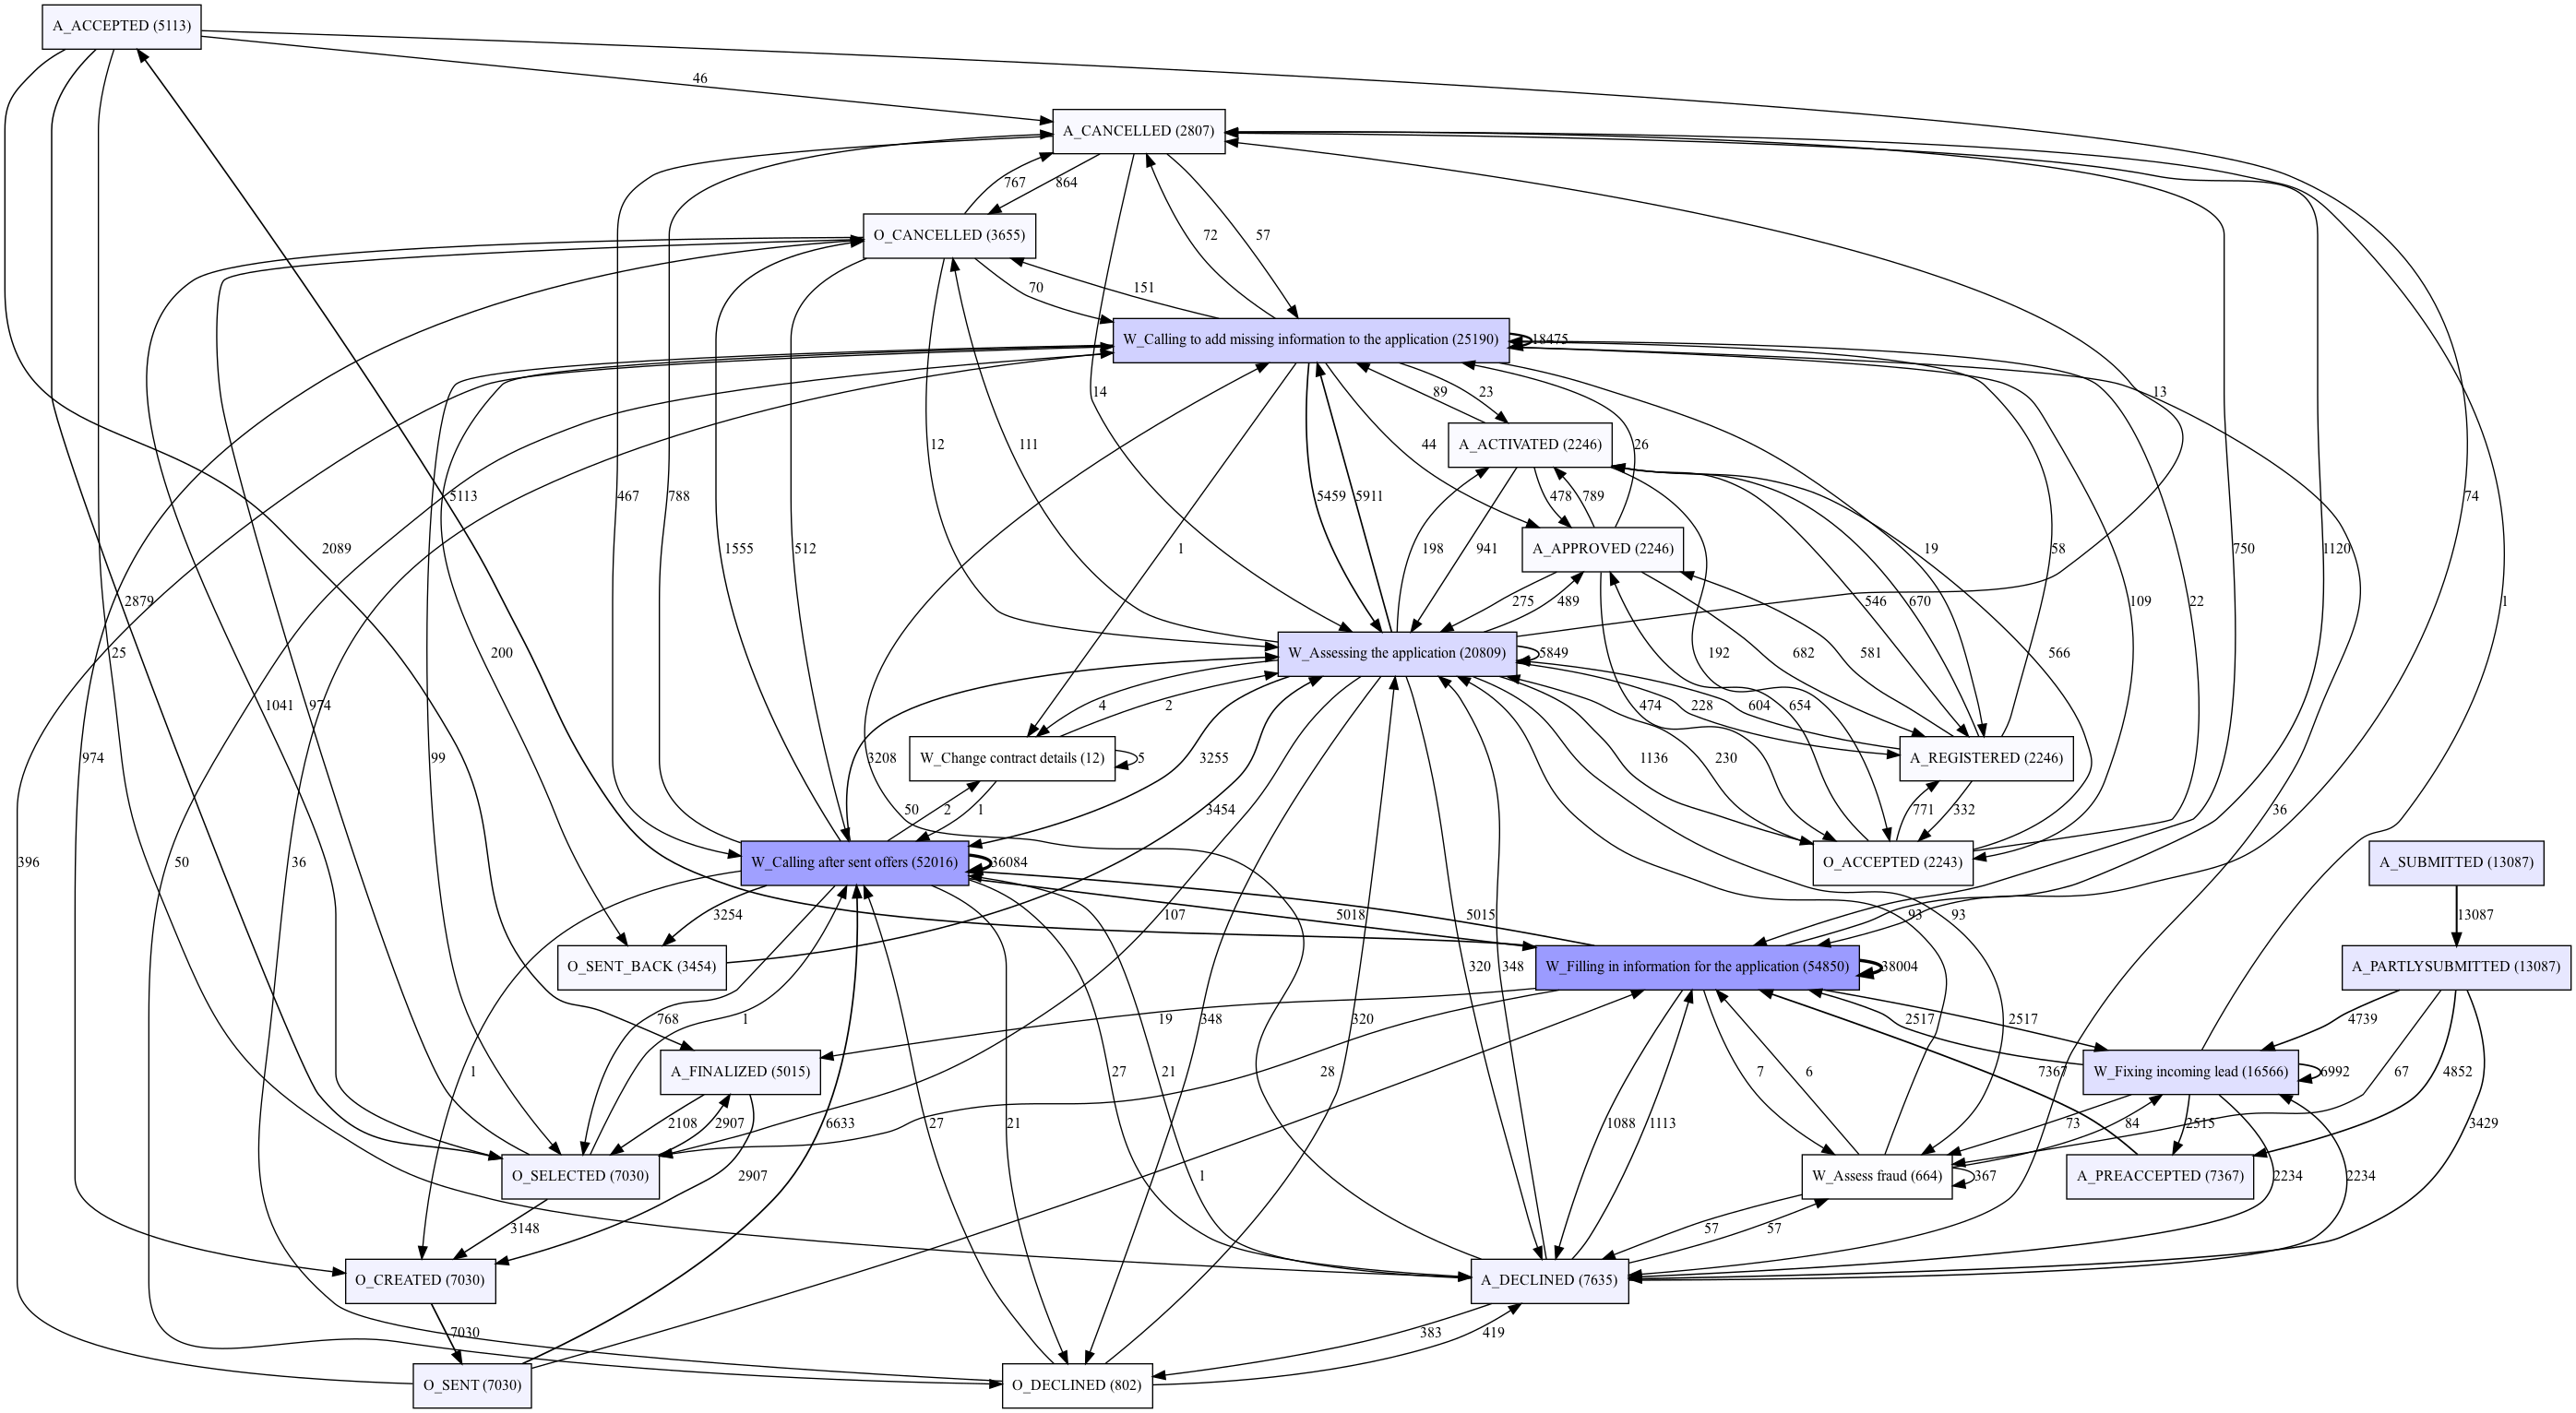

In [89]:

# for DFG- loan process overlaying frequency information from the log

gviz = dfg_visualization.apply(loan_process_dfg, log=event_log_xes, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)


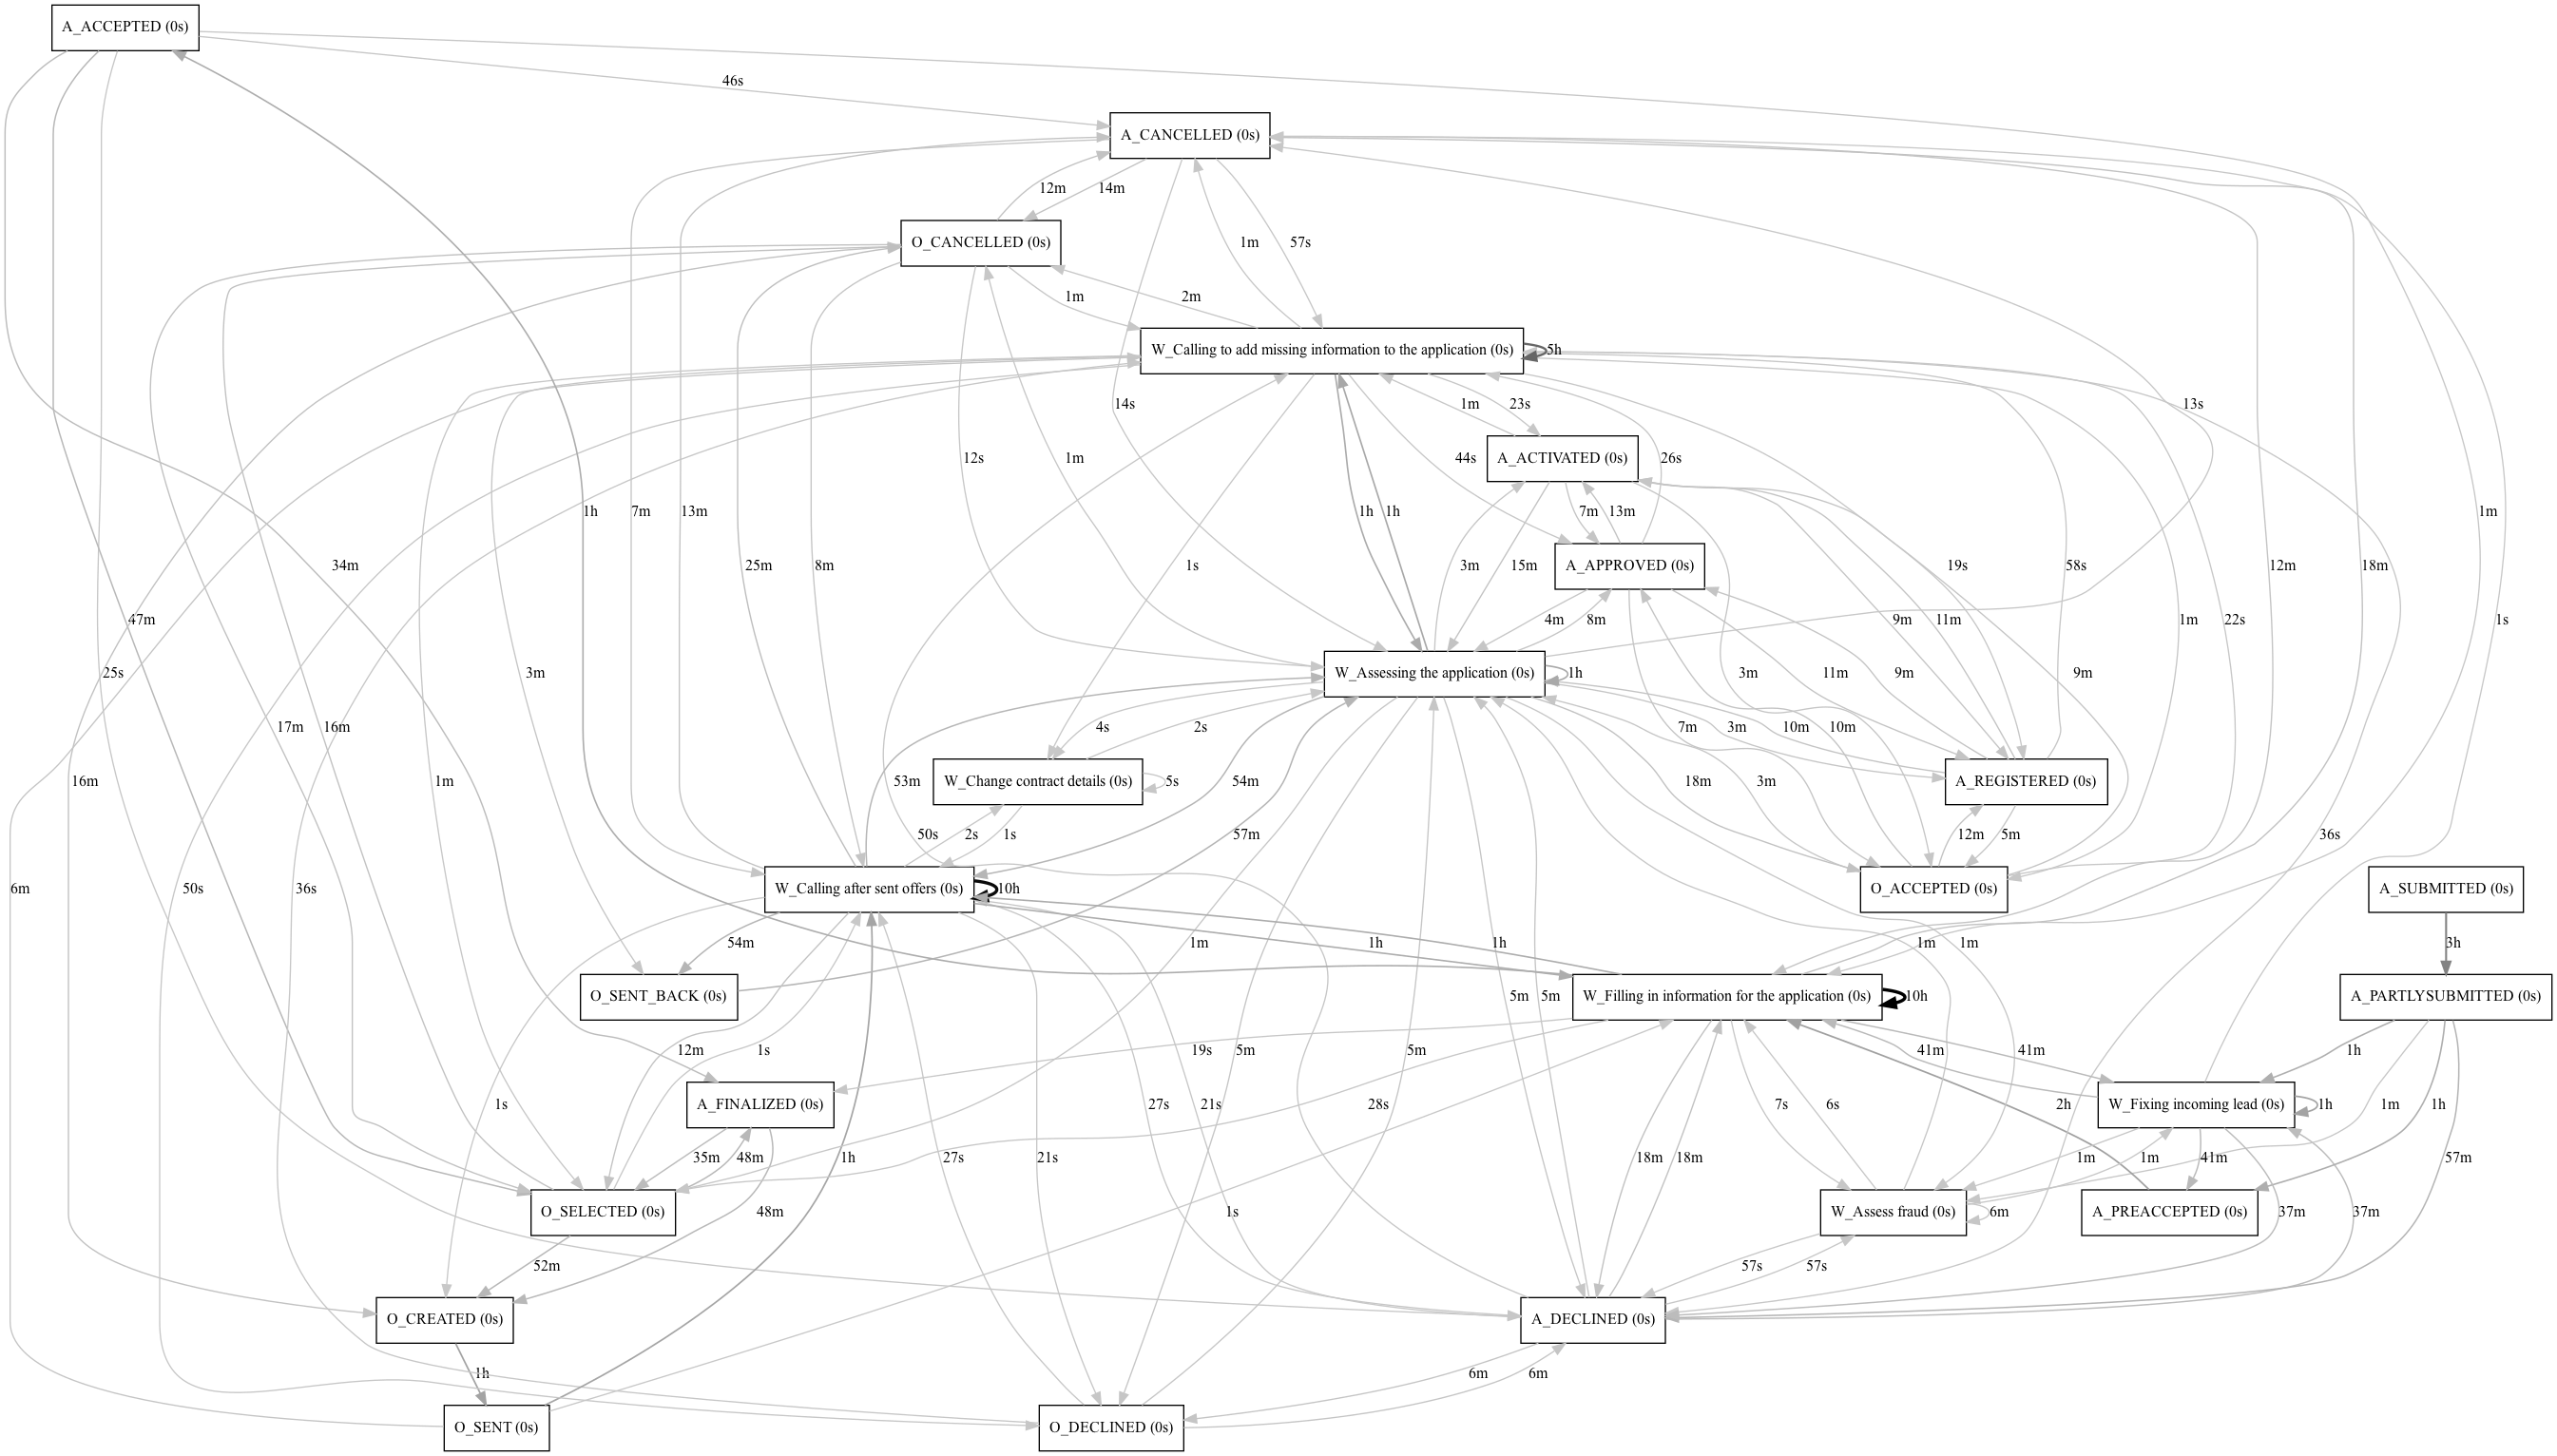

In [90]:

# for DFG- loan process overlaying Performance information from the log

gviz = dfg_visualization.apply(loan_process_dfg, log=event_log_xes, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/4366 [00:00<?, ?it/s]

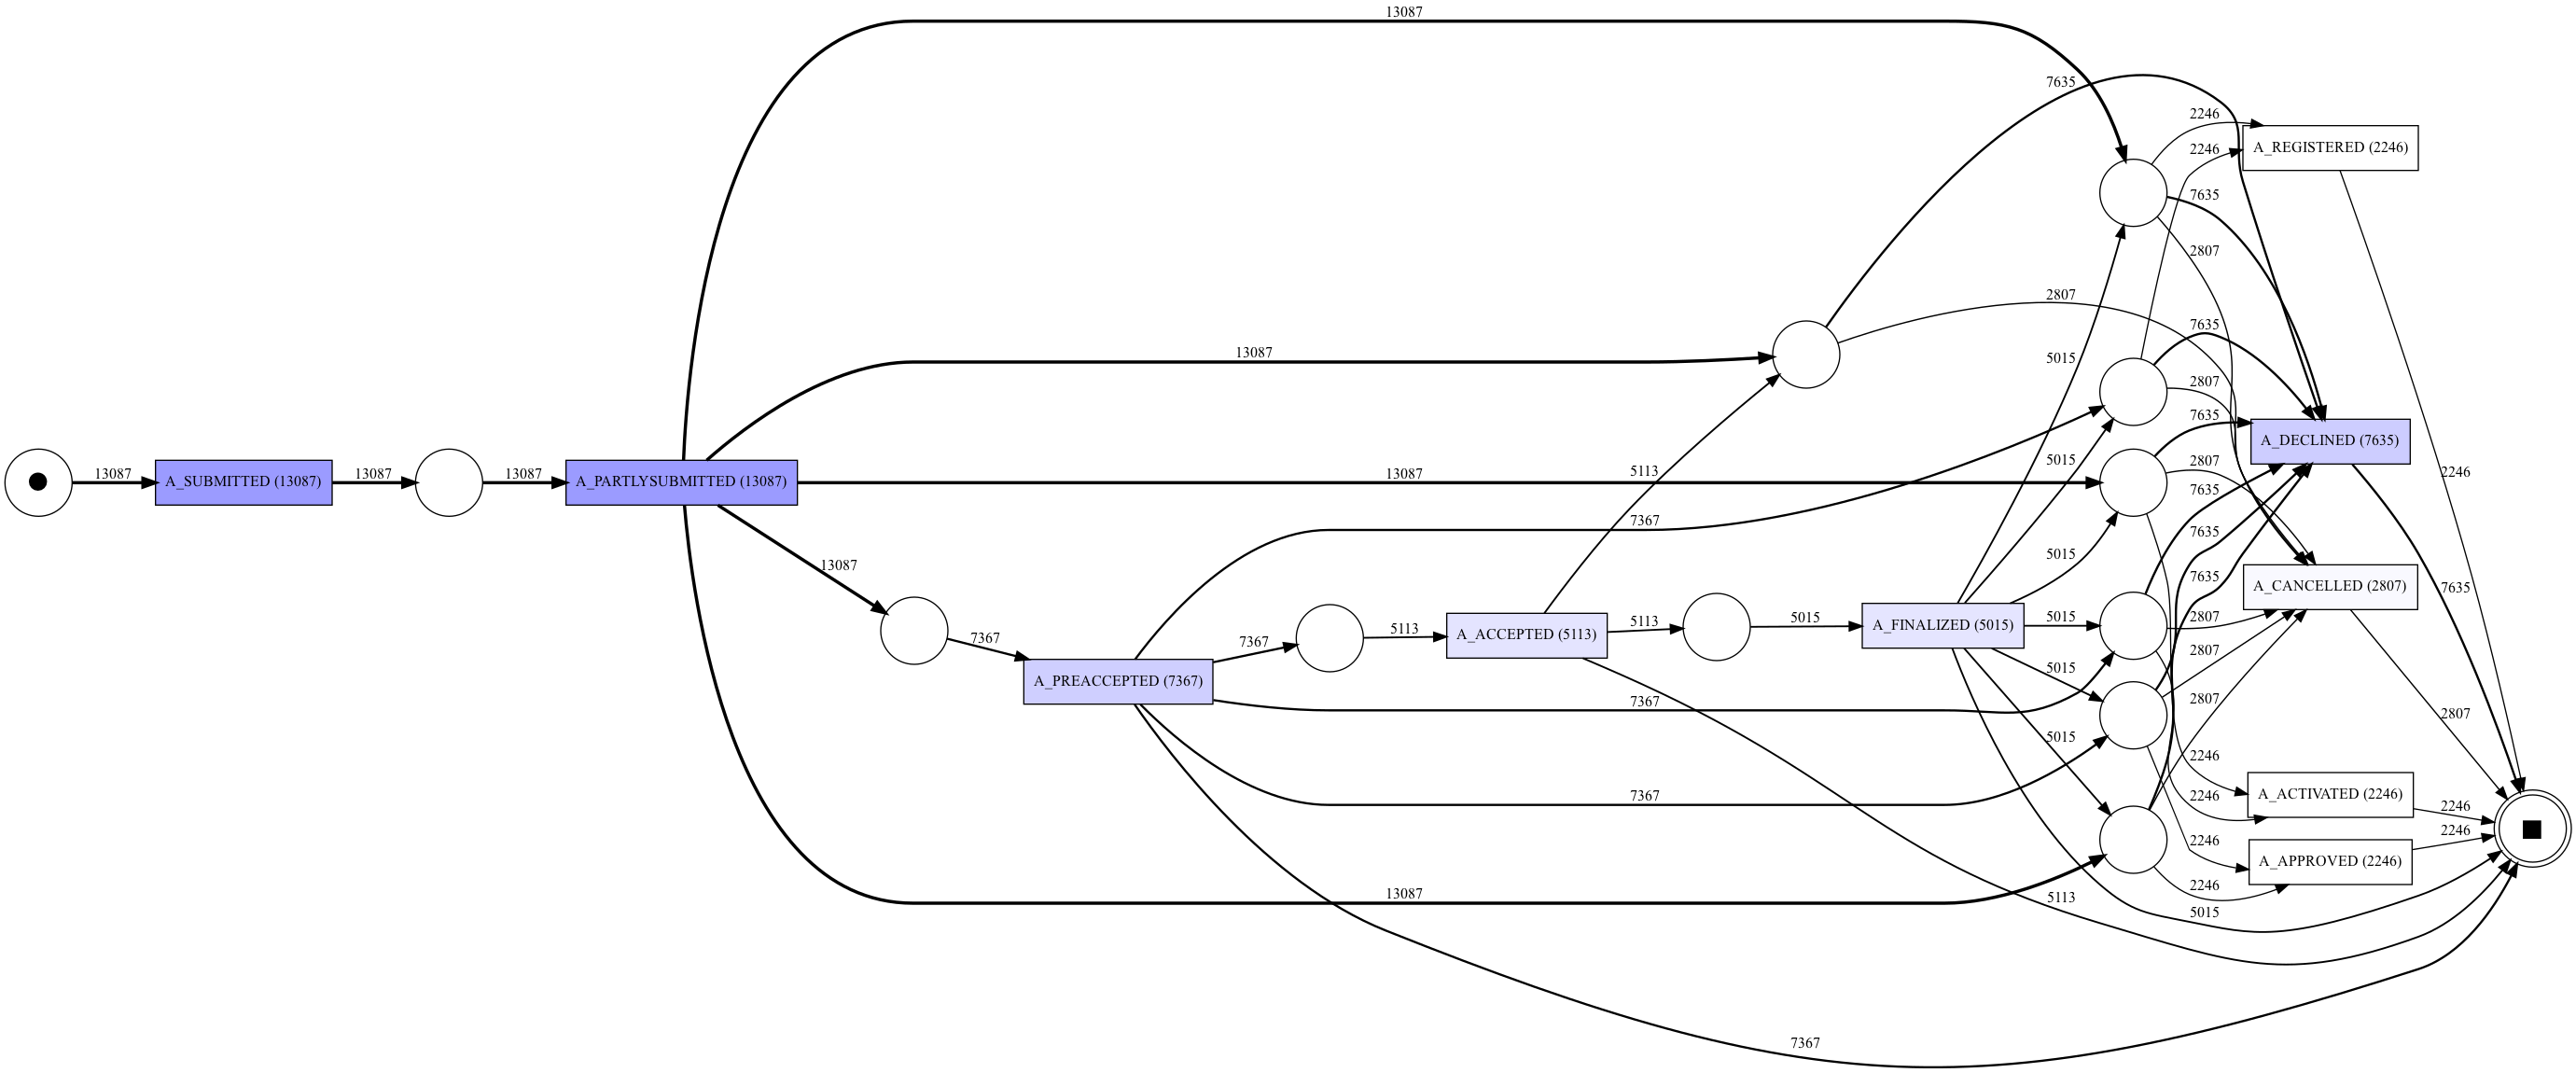

In [91]:
# for Alpha miner- Application Status process overlaying frequency information from the log


gviz = pn_visualizer.apply(net3, im3, fm3, variant=pn_visualizer.Variants.FREQUENCY, log=event_log_xes)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/4366 [00:00<?, ?it/s]

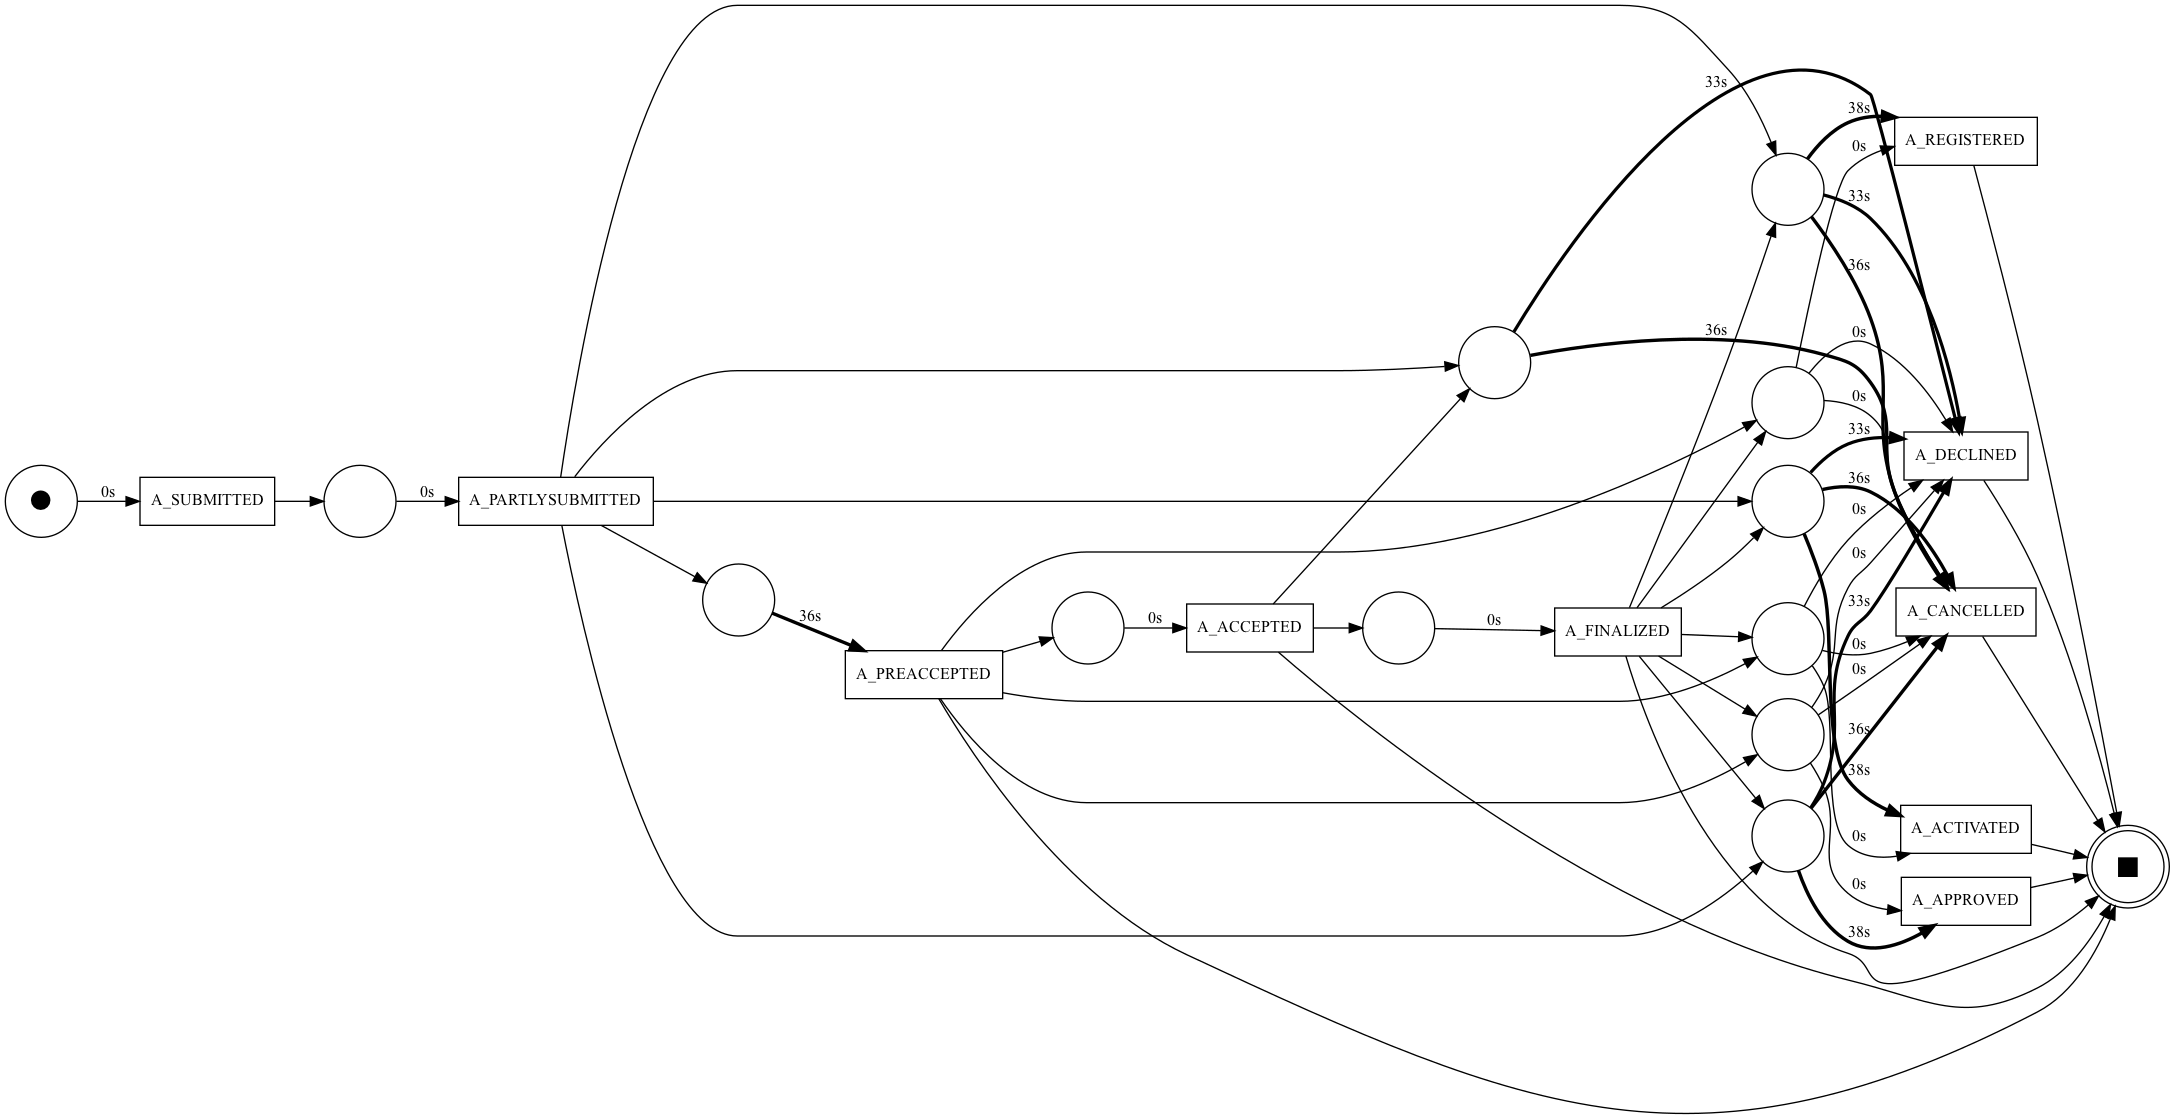

In [92]:
# for Alpha miner- Application Status process overlaying Performance information from the log


gviz = pn_visualizer.apply(net3, im3, fm3, variant=pn_visualizer.Variants.PERFORMANCE, log=event_log_xes)
pn_visualizer.view(gviz)


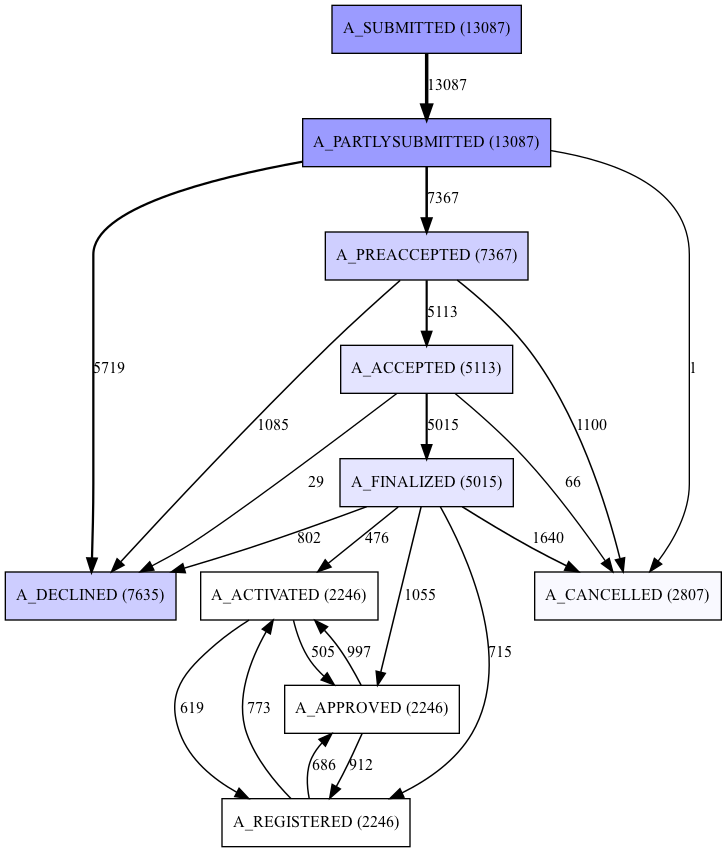

In [93]:
# for DFG- Application Status process overlaying frequency information from the log

gviz = dfg_visualization.apply(app_status_process_dfg, log=app_status_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)


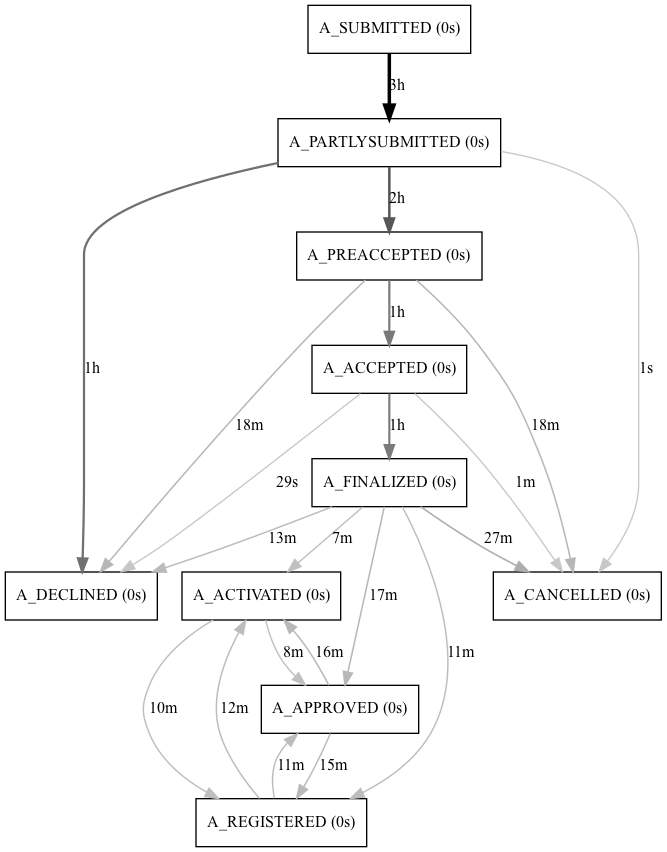

In [94]:
# for DFG- Application Status process overlaying Performance information from the log

gviz = dfg_visualization.apply(app_status_process_dfg, log=app_status_log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

In [95]:
all_case_durations = pm4py.get_all_case_durations(event_log_xes)
all_case_durations

[1.8549997806549072,
 1.8960001468658447,
 2.003000020980835,
 2.013000011444092,
 2.060999870300293,
 2.0880000591278076,
 2.0969998836517334,
 2.0969998836517334,
 2.11899995803833,
 2.138000011444092,
 2.1579999923706055,
 2.184000015258789,
 2.194000005722046,
 2.195000171661377,
 2.2130000591278076,
 2.2200000286102295,
 2.2789998054504395,
 2.323000192642212,
 2.3320000171661377,
 2.3369998931884766,
 2.3490002155303955,
 2.3530001640319824,
 2.381999969482422,
 2.3910000324249268,
 2.392000198364258,
 2.425999879837036,
 2.440000057220459,
 2.4579999446868896,
 2.4589998722076416,
 2.4800000190734863,
 2.4850001335144043,
 2.48799991607666,
 2.500999927520752,
 2.505000114440918,
 2.5160000324249268,
 2.5180001258850098,
 2.5329999923706055,
 2.574000120162964,
 2.578000068664551,
 2.5850000381469727,
 2.609999895095825,
 2.627000093460083,
 2.6379997730255127,
 2.680000066757202,
 2.684000015258789,
 2.69100022315979,
 2.697999954223633,
 2.705000162124634,
 2.7129998207092285,

In [96]:
rework = pm4py.get_rework_cases_per_activity(event_log_xes)
rework

{'W_Filling in information for the application': 7367,
 'W_Calling after sent offers': 5011,
 'W_Assessing the application': 3210,
 'O_SELECTED': 1438,
 'O_CREATED': 1438,
 'O_SENT': 1438,
 'O_CANCELLED': 749,
 'W_Fixing incoming lead': 4755,
 'W_Calling to add missing information to the application': 1647,
 'O_SENT_BACK': 197,
 'W_Assess fraud': 108,
 'W_Change contract details': 4}

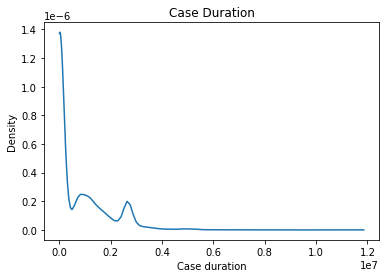

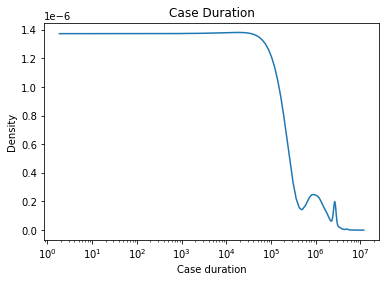

In [97]:
from pm4py.util import constants
from pm4py.statistics.traces.generic.log import case_statistics
x, y = case_statistics.get_kde_caseduration(event_log_xes, parameters={constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})

from pm4py.visualization.graphs import visualizer as graphs_visualizer

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)

gviz = graphs_visualizer.apply_semilogx(x, y, variant=graphs_visualizer.Variants.CASES)
graphs_visualizer.view(gviz)
         


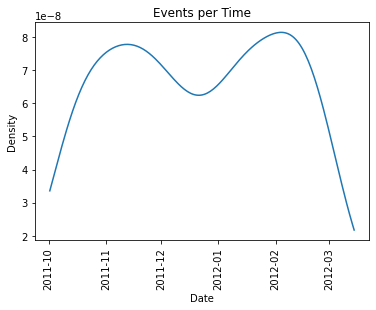

In [98]:

from pm4py.algo.filtering.log.attributes import attributes_filter

x, y = attributes_filter.get_kde_date_attribute(app_status_log, attribute="time:timestamp")

from pm4py.visualization.graphs import visualizer as graphs_visualizer

gviz = graphs_visualizer.apply_plot(x, y, variant=graphs_visualizer.Variants.DATES)
graphs_visualizer.view(gviz)
     